# Introduction

- Predictive maintenance on NASA's turbofan engine degradation dataset (CMAPSS). 
- Datasets include simulations of multiple turbofan engines over time, each row contains the following information:
  1. Engine unit number
  2. Time, in cycles
  3. Three operational settings
  4. 21 sensor readings.




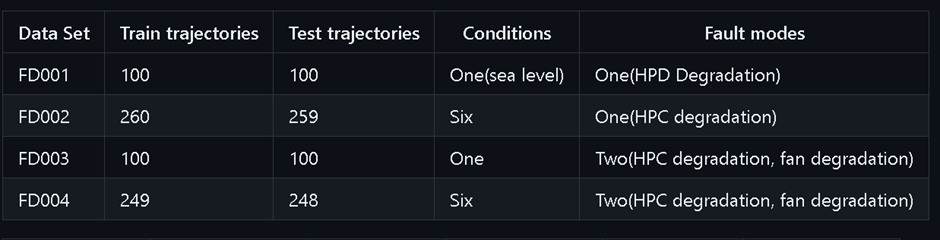

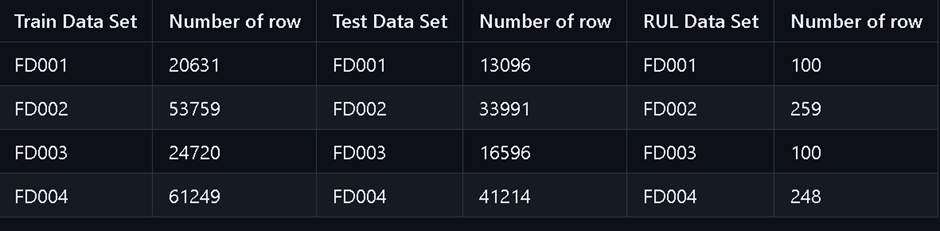

# Importing Necessary Libraries

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
pd.set_option("display.max_rows", None)


# Importing the Dataset

In [2]:

# define column names for easy indexing
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1,22)]

col_names = index_names + setting_names + sensor_names

# read data
train = pd.read_csv('train_FD001.txt',sep='\s+', header=None, names=col_names)
test = pd.read_csv('test_FD001.txt',sep='\s+', header=None, names=col_names)
y_test = pd.read_csv('RUL_FD001.txt', sep='\s+', header=None, names=['RUL'])

# Train data contains all features (Unit Number + setting parameters & sensor parameters)
# Test data contains all features (Unit Number + setting parameters & sensor parameters)
# Y_test contains RUL for the test data.
train.head()

unit_nr  time_cycles  setting_1  setting_2  setting_3     s_1     s_2  \
0        1            1    -0.0007    -0.0004      100.0  518.67  641.82   
1        1            2     0.0019    -0.0003      100.0  518.67  642.15   
2        1            3    -0.0043     0.0003      100.0  518.67  642.35   
3        1            4     0.0007     0.0000      100.0  518.67  642.35   
4        1            5    -0.0019    -0.0002      100.0  518.67  642.37   

       s_3      s_4    s_5  ...    s_12     s_13     s_14    s_15  s_16  s_17  \
0  1589.70  1400.60  14.62  ...  521.66  2388.02  8138.62  8.4195  0.03   392   
1  1591.82  1403.14  14.62  ...  522.28  2388.07  8131.49  8.4318  0.03   392   
2  1587.99  1404.20  14.62  ...  522.42  2388.03  8133.23  8.4178  0.03   390   
3  1582.79  1401.87  14.62  ...  522.86  2388.08  8133.83  8.3682  0.03   392   
4  1582.85  1406.22  14.62  ...  522.19  2388.04  8133.80  8.4294  0.03   393   

   s_18   s_19   s_20     s_21  
0  2388  100.0  39.06  23.4190  
1  2388  100.0  39.00  23.4236  
2  2388  100.0  38.95  23.3442  
3  2388  100.0  38.88  23.3739  
4  2388  100.0  38.90  23.4044  

[5 rows x 26 columns]

In [3]:
train.shape

(20631, 26)

In [4]:
y_test.shape

(100, 1)

In [5]:
train['unit_nr'].unique()

# There are 100 no unique engines.

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100], dtype=int64)

Note:  for Test Dataset Since the true RUL values for the test set are only provided for the last time cycle of each engine, 
therefore the test dataset will be subsetted to represent the same.

In [6]:
test.shape

(13096, 26)

In [7]:
# Since the true RUL values (y_test) for the test set are only provided for the last time cycle of each enginge, 
# the test set is subsetted to represent the same
test = test.groupby('unit_nr').last().reset_index().drop(['unit_nr','time_cycles'], axis=1)

In [8]:
y_test.shape

# RUL value for 100 no of engines.

(100, 1)

In [9]:
test.shape
# Now test data contains entries for 100 no of engines with their RUL.

(100, 24)

# Data Pre-Processing + Data Visualization

In [10]:
train.describe()

unit_nr   time_cycles     setting_1     setting_2  setting_3  \
count  20631.000000  20631.000000  20631.000000  20631.000000    20631.0   
mean      51.506568    108.807862     -0.000009      0.000002      100.0   
std       29.227633     68.880990      0.002187      0.000293        0.0   
min        1.000000      1.000000     -0.008700     -0.000600      100.0   
25%       26.000000     52.000000     -0.001500     -0.000200      100.0   
50%       52.000000    104.000000      0.000000      0.000000      100.0   
75%       77.000000    156.000000      0.001500      0.000300      100.0   
max      100.000000    362.000000      0.008700      0.000600      100.0   

                s_1           s_2           s_3           s_4           s_5  \
count  2.063100e+04  20631.000000  20631.000000  20631.000000  2.063100e+04   
mean   5.186700e+02    642.680934   1590.523119   1408.933782  1.462000e+01   
std    6.537152e-11      0.500053      6.131150      9.000605  3.394700e-12   
min    5.186700e+02    641.210000   1571.040000   1382.250000  1.462000e+01   
25%    5.186700e+02    642.325000   1586.260000   1402.360000  1.462000e+01   
50%    5.186700e+02    642.640000   1590.100000   1408.040000  1.462000e+01   
75%    5.186700e+02    643.000000   1594.380000   1414.555000  1.462000e+01   
max    5.186700e+02    644.530000   1616.910000   1441.490000  1.462000e+01   

       ...          s_12          s_13          s_14          s_15  \
count  ...  20631.000000  20631.000000  20631.000000  20631.000000   
mean   ...    521.413470   2388.096152   8143.752722      8.442146   
std    ...      0.737553      0.071919     19.076176      0.037505   
min    ...    518.690000   2387.880000   8099.940000      8.324900   
25%    ...    520.960000   2388.040000   8133.245000      8.414900   
50%    ...    521.480000   2388.090000   8140.540000      8.438900   
75%    ...    521.950000   2388.140000   8148.310000      8.465600   
max    ...    523.380000   2388.560000   8293.720000      8.584800   

               s_16          s_17     s_18     s_19          s_20  \
count  2.063100e+04  20631.000000  20631.0  20631.0  20631.000000   
mean   3.000000e-02    393.210654   2388.0    100.0     38.816271   
std    1.556432e-14      1.548763      0.0      0.0      0.180746   
min    3.000000e-02    388.000000   2388.0    100.0     38.140000   
25%    3.000000e-02    392.000000   2388.0    100.0     38.700000   
50%    3.000000e-02    393.000000   2388.0    100.0     38.830000   
75%    3.000000e-02    394.000000   2388.0    100.0     38.950000   
max    3.000000e-02    400.000000   2388.0    100.0     39.430000   

               s_21  
count  20631.000000  
mean      23.289705  
std        0.108251  
min       22.894200  
25%       23.221800  
50%       23.297900  
75%       23.366800  
max       23.618400  

[8 rows x 26 columns]

In [11]:
# Remove setting_3 column as we can see that it's value is not changing theerfore will not not add any information to our 
# prediction
train=train.drop('setting_3',axis=1)

In [12]:
# Adding RUL (Ramining Useful Life) to the train dataset
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

train = add_remaining_useful_life(train)
train[sensor_names+['RUL']].head()

s_1     s_2      s_3      s_4    s_5    s_6     s_7      s_8      s_9  \
0  518.67  641.82  1589.70  1400.60  14.62  21.61  554.36  2388.06  9046.19   
1  518.67  642.15  1591.82  1403.14  14.62  21.61  553.75  2388.04  9044.07   
2  518.67  642.35  1587.99  1404.20  14.62  21.61  554.26  2388.08  9052.94   
3  518.67  642.35  1582.79  1401.87  14.62  21.61  554.45  2388.11  9049.48   
4  518.67  642.37  1582.85  1406.22  14.62  21.61  554.00  2388.06  9055.15   

   s_10  ...     s_13     s_14    s_15  s_16  s_17  s_18   s_19   s_20  \
0   1.3  ...  2388.02  8138.62  8.4195  0.03   392  2388  100.0  39.06   
1   1.3  ...  2388.07  8131.49  8.4318  0.03   392  2388  100.0  39.00   
2   1.3  ...  2388.03  8133.23  8.4178  0.03   390  2388  100.0  38.95   
3   1.3  ...  2388.08  8133.83  8.3682  0.03   392  2388  100.0  38.88   
4   1.3  ...  2388.04  8133.80  8.4294  0.03   393  2388  100.0  38.90   

      s_21  RUL  
0  23.4190  191  
1  23.4236  190  
2  23.3442  189  
3  23.3739  188  
4  23.4044  187  

[5 rows x 22 columns]

In [13]:
train.head(5)

unit_nr  time_cycles  setting_1  setting_2     s_1     s_2      s_3  \
0        1            1    -0.0007    -0.0004  518.67  641.82  1589.70   
1        1            2     0.0019    -0.0003  518.67  642.15  1591.82   
2        1            3    -0.0043     0.0003  518.67  642.35  1587.99   
3        1            4     0.0007     0.0000  518.67  642.35  1582.79   
4        1            5    -0.0019    -0.0002  518.67  642.37  1582.85   

       s_4    s_5    s_6  ...     s_13     s_14    s_15  s_16  s_17  s_18  \
0  1400.60  14.62  21.61  ...  2388.02  8138.62  8.4195  0.03   392  2388   
1  1403.14  14.62  21.61  ...  2388.07  8131.49  8.4318  0.03   392  2388   
2  1404.20  14.62  21.61  ...  2388.03  8133.23  8.4178  0.03   390  2388   
3  1401.87  14.62  21.61  ...  2388.08  8133.83  8.3682  0.03   392  2388   
4  1406.22  14.62  21.61  ...  2388.04  8133.80  8.4294  0.03   393  2388   

    s_19   s_20     s_21  RUL  
0  100.0  39.06  23.4190  191  
1  100.0  39.00  23.4236  190  
2  100.0  38.95  23.3442  189  
3  100.0  38.88  23.3739  188  
4  100.0  38.90  23.4044  187  

[5 rows x 26 columns]

## Plotting of RUL

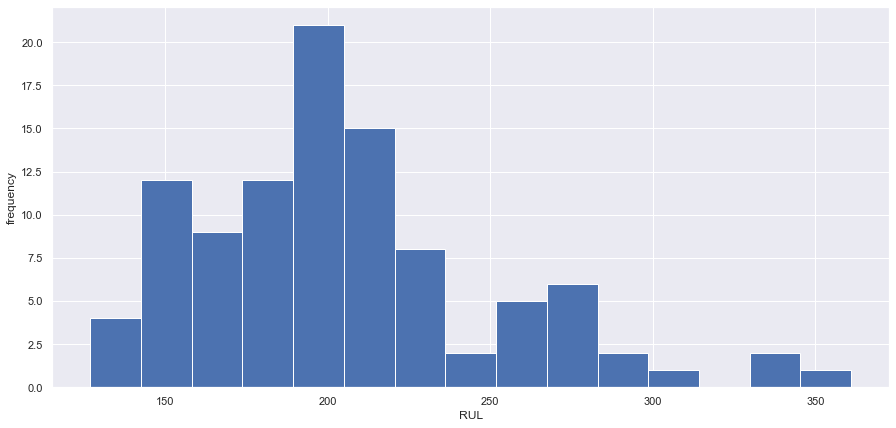

In [14]:
# distribution of RUL, similar to the 'describe function' of time_cycles above, but visual
df_max_rul = train[['unit_nr', 'RUL']].groupby('unit_nr').max().reset_index()
df_max_rul['RUL'].hist(bins=15, figsize=(15,7))
plt.xlabel('RUL')
plt.ylabel('frequency')
plt.show()

In [15]:
# We can see the RUL for engine is bit skewed on left side. This may affect perfomance of the model however as of now we will keep it as it.


## Plotting of Sensor Values Vs RUL

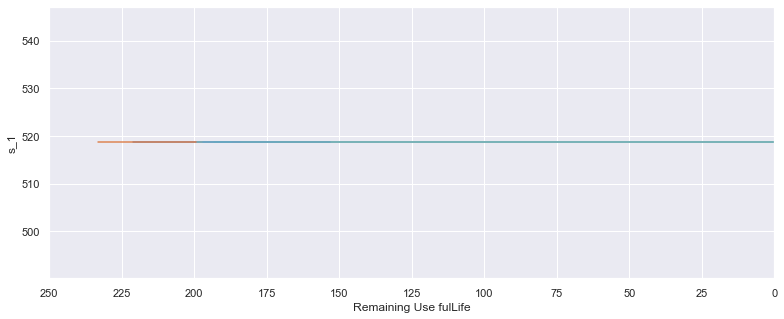

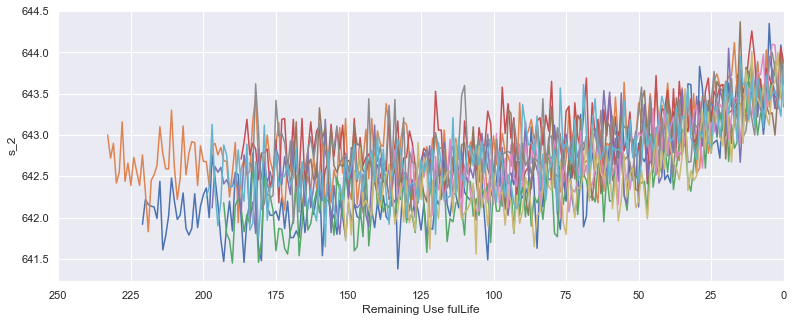

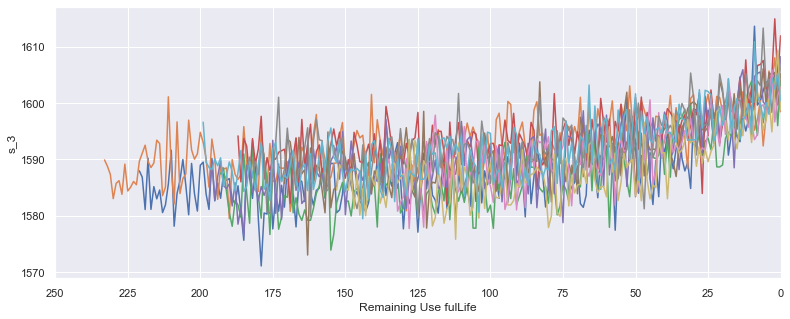

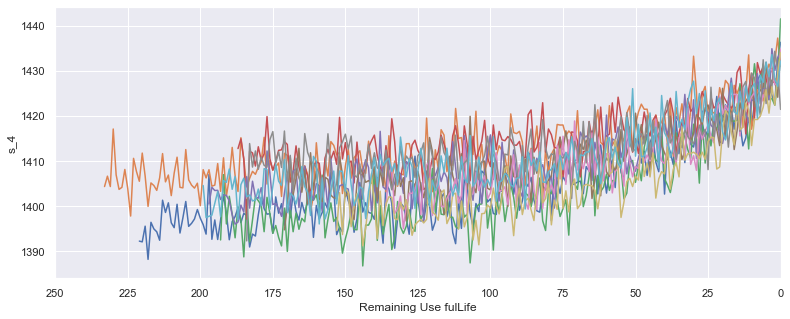

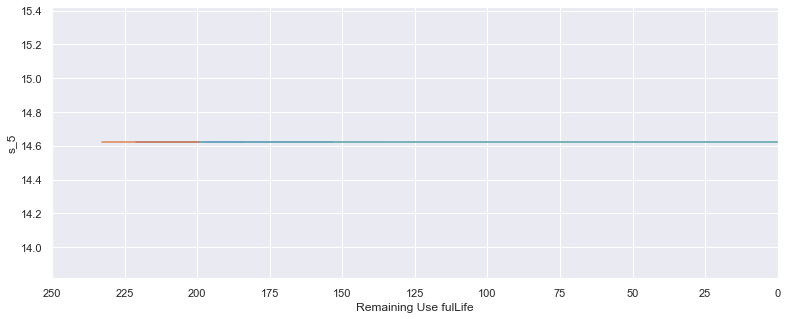

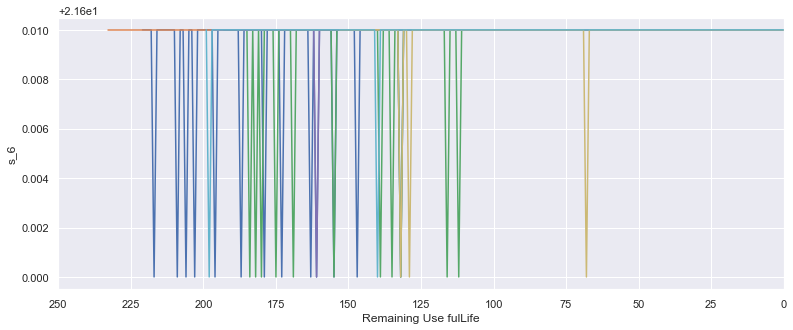

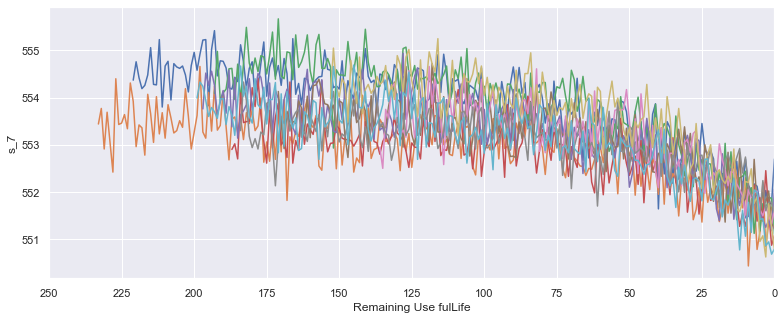

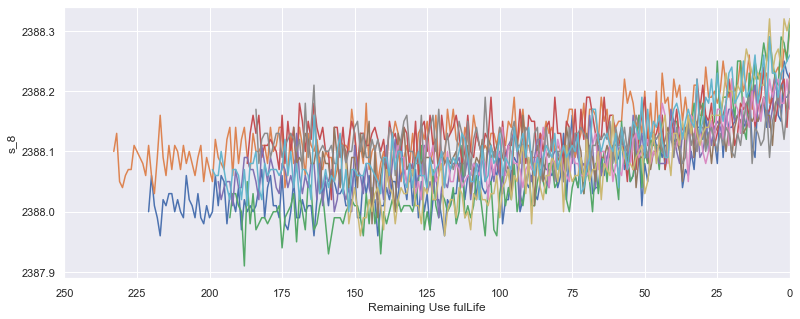

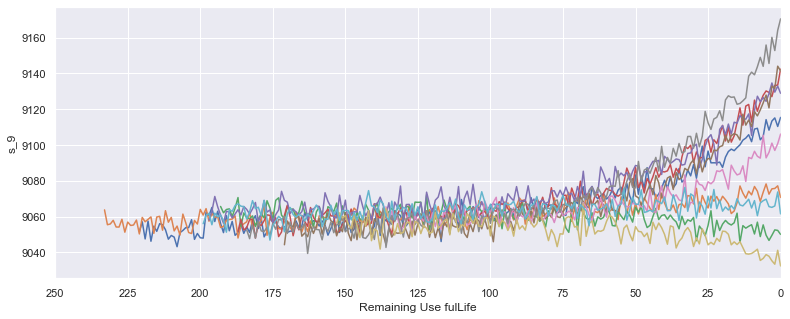

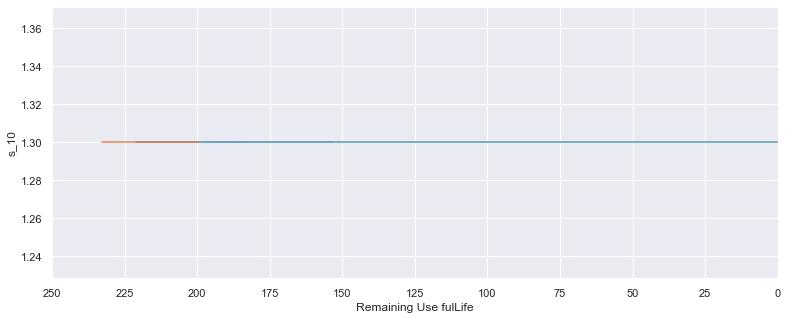

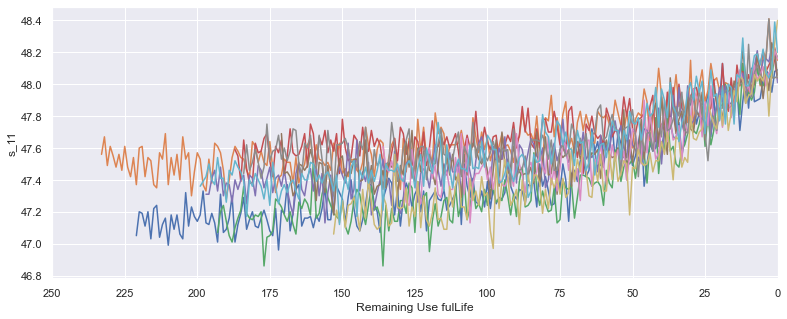

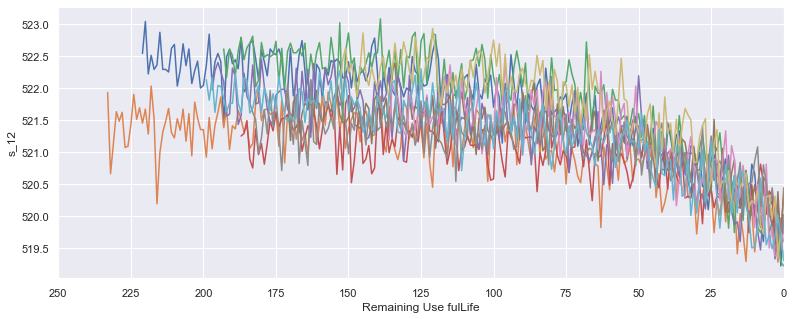

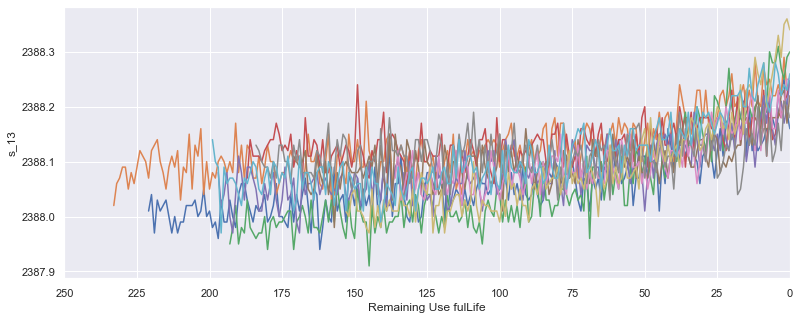

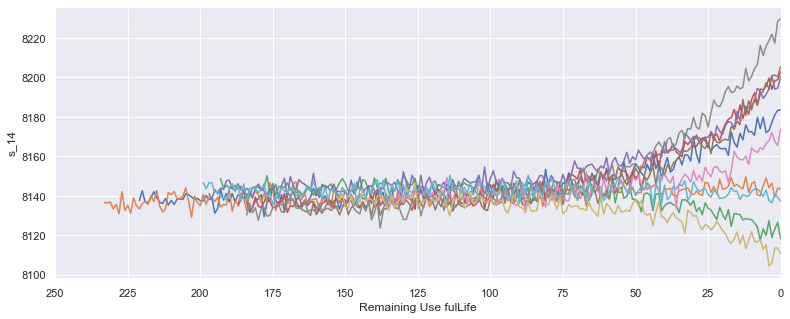

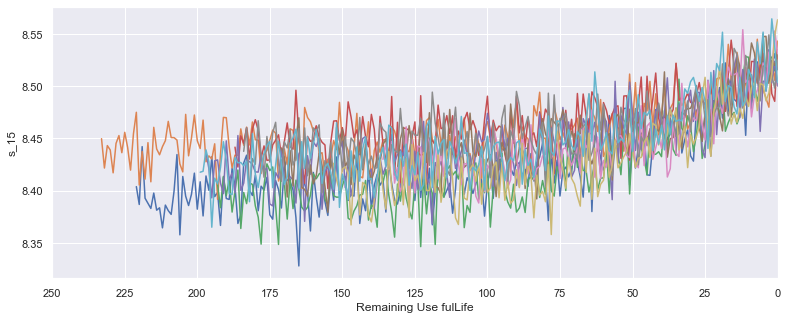

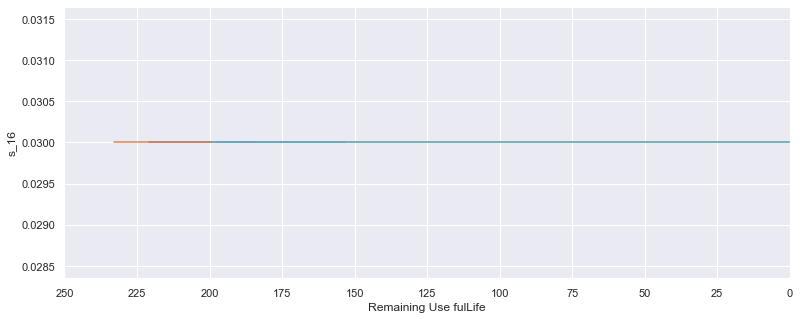

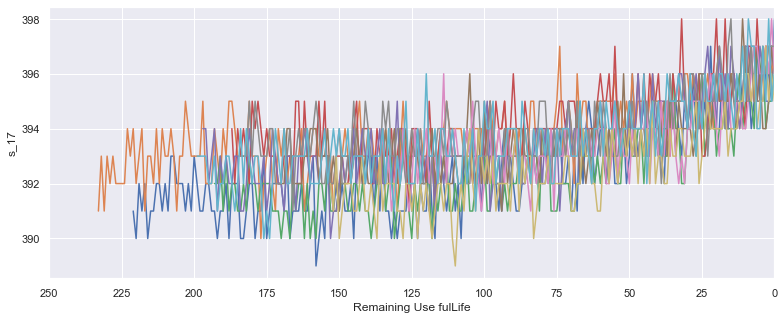

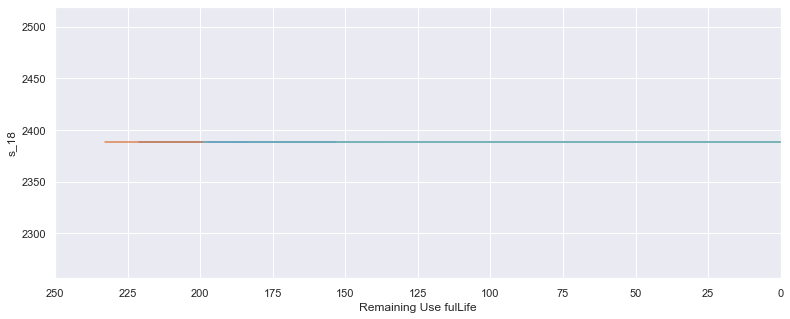

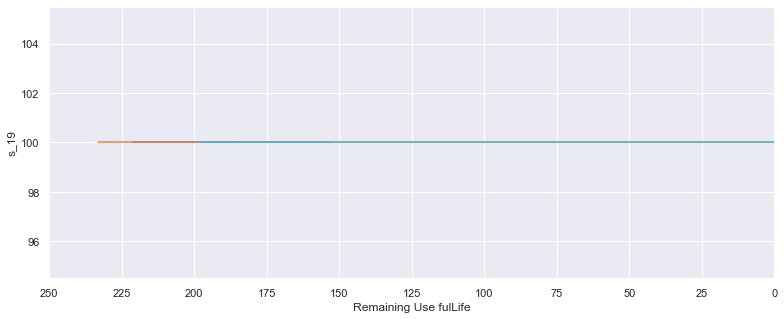

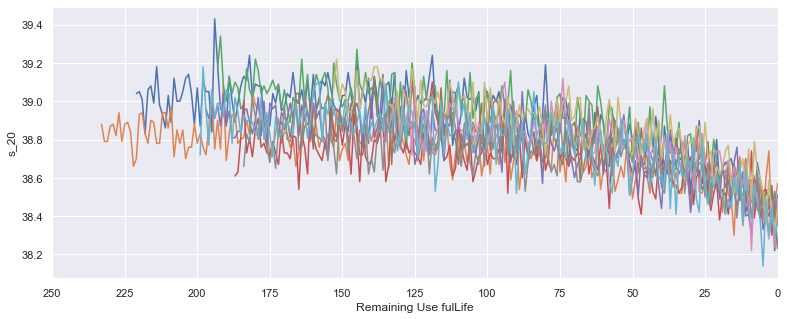

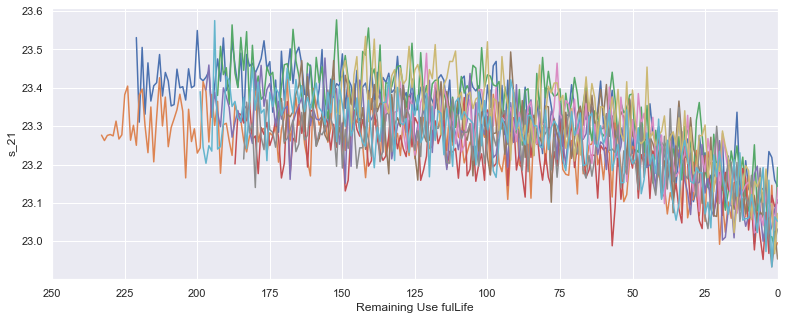

In [16]:
def plot_sensor(sensor_name):
    plt.figure(figsize=(13,5))
    for i in train['unit_nr'].unique():
        if (i % 10 == 0):  # only plot every 10th unit_nr
            plt.plot('RUL', sensor_name, 
                     data=train[train['unit_nr']==i])
    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 275, 25))
    plt.ylabel(sensor_name)
    plt.xlabel('Remaining Use fulLife')
    plt.show()

for sensor_name in sensor_names:
    plot_sensor(sensor_name)

- Based on the plots you can see sensors 1, 5, 6, 10, 16, 18 and 19 hold no information related to Remaining Useful Life as the sensor values remain constant throughout time.
- As on now we will keep all features and will remove non-important features after calculating correlation value of each sensor variable with the RUL.

## Boxplots to find outliers

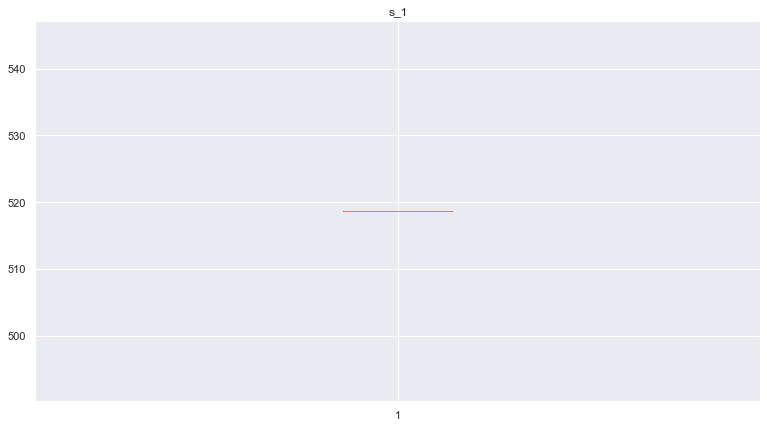

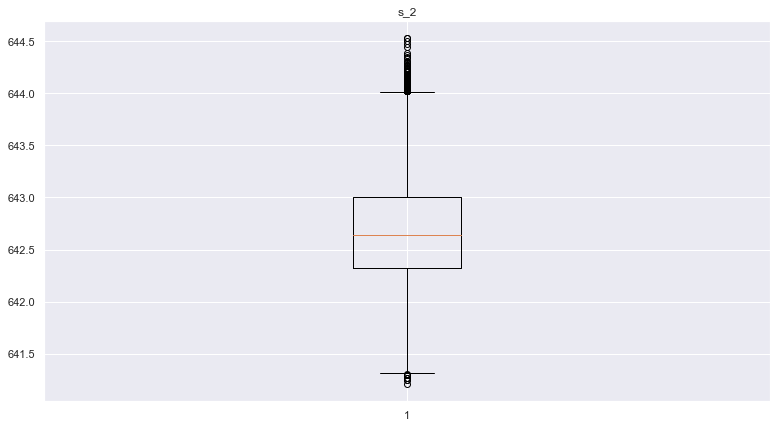

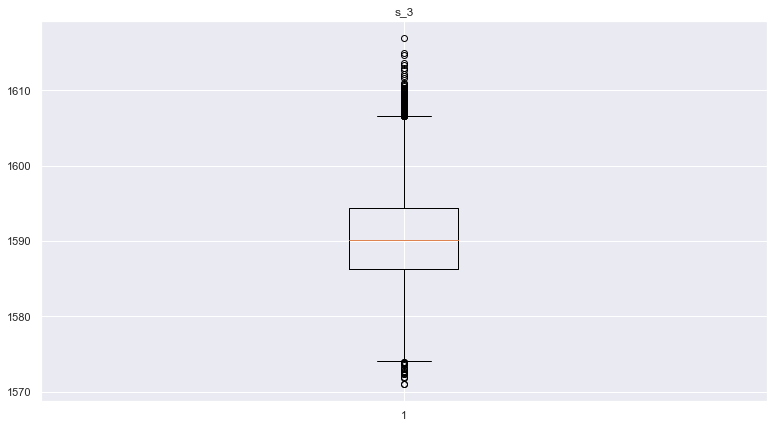

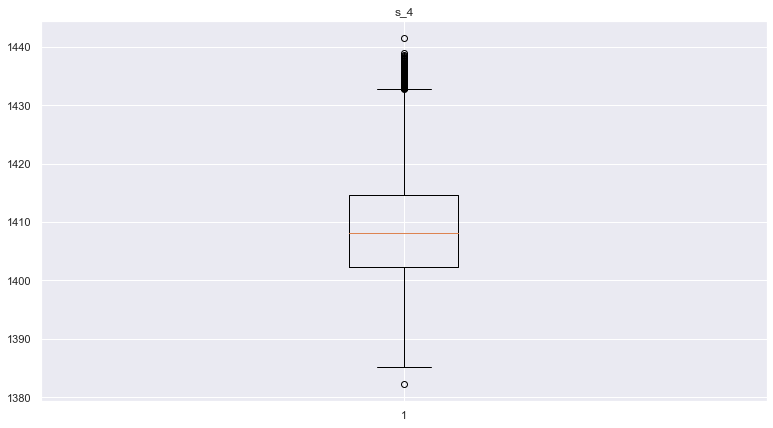

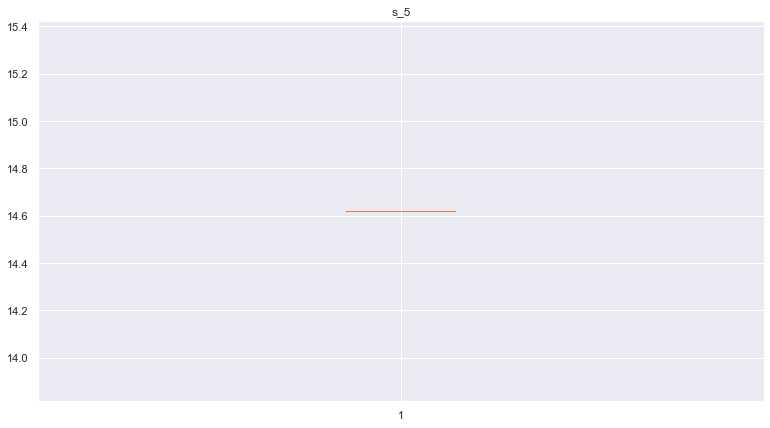

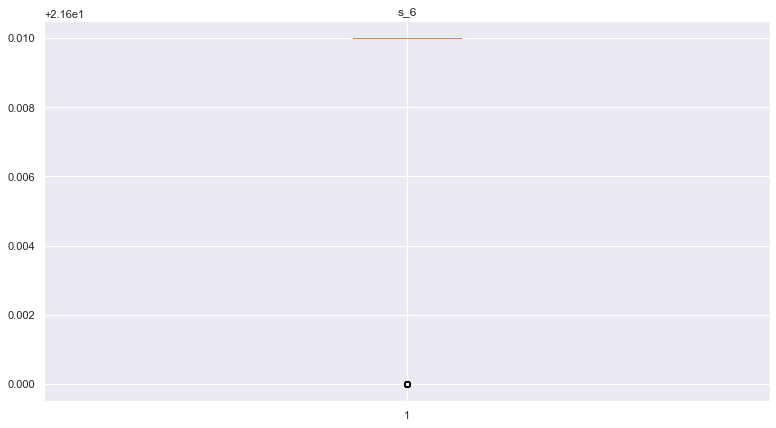

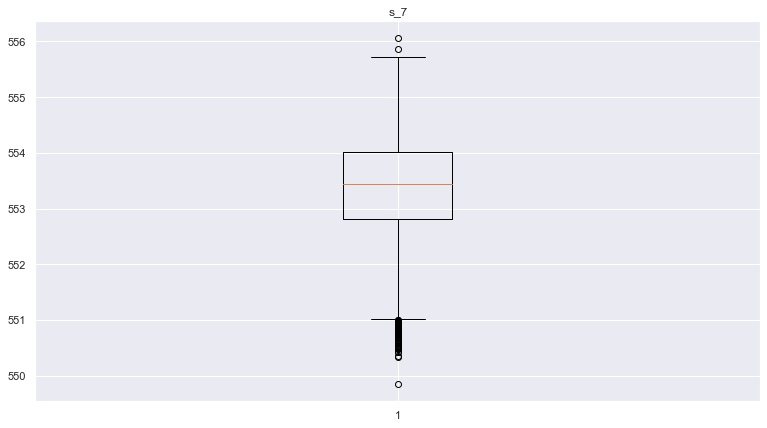

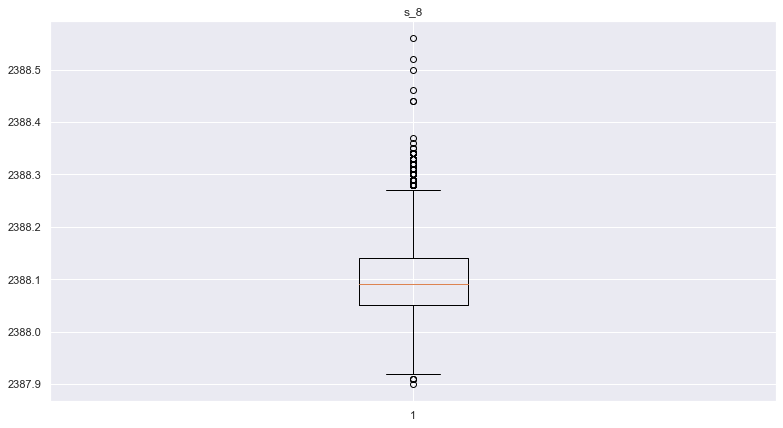

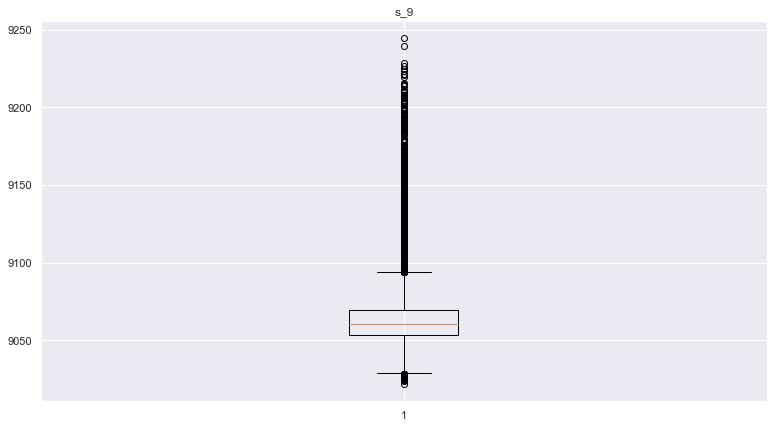

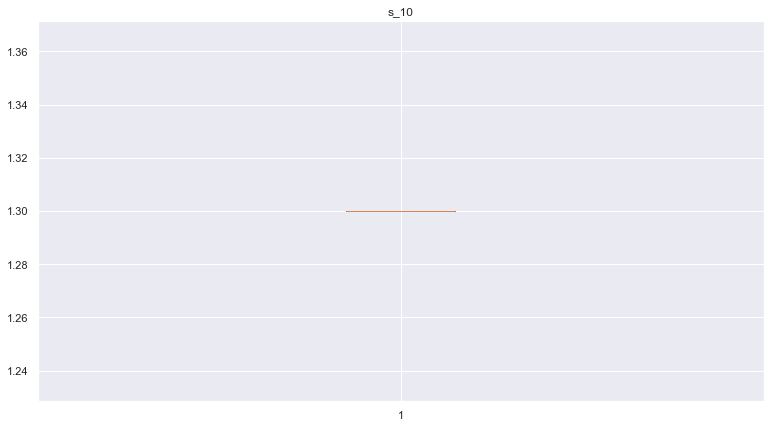

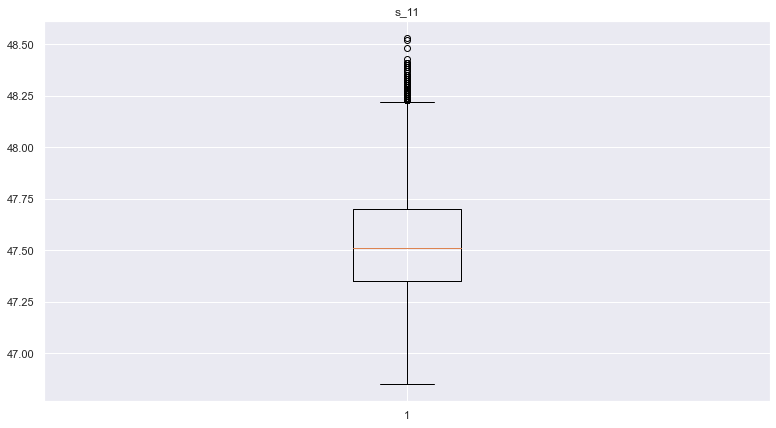

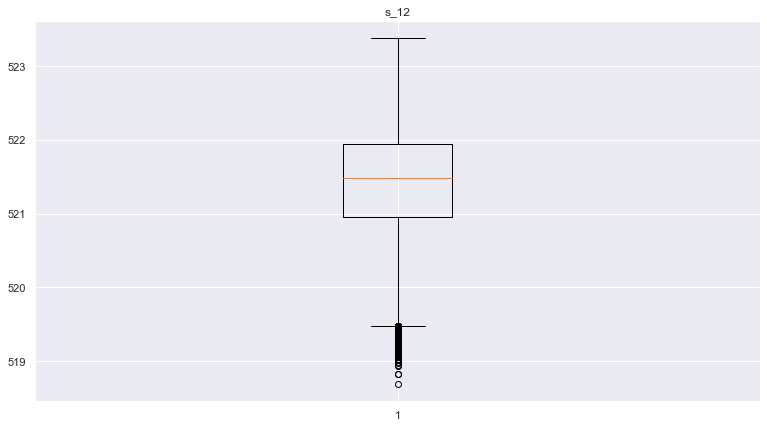

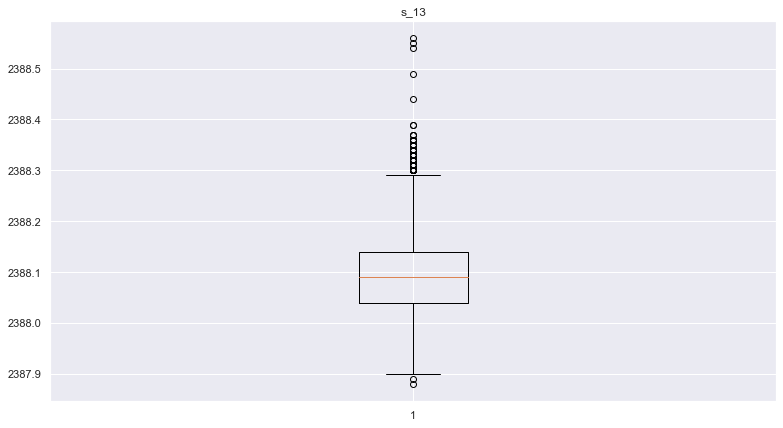

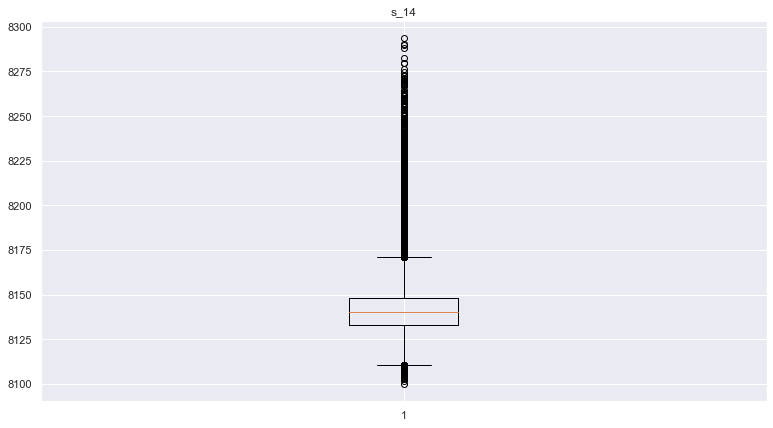

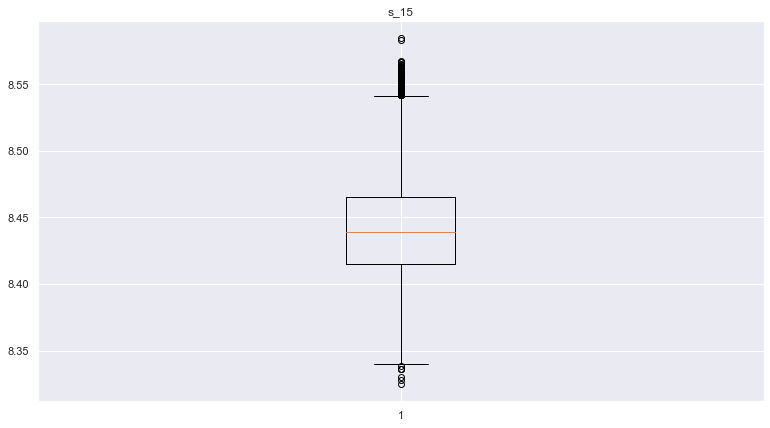

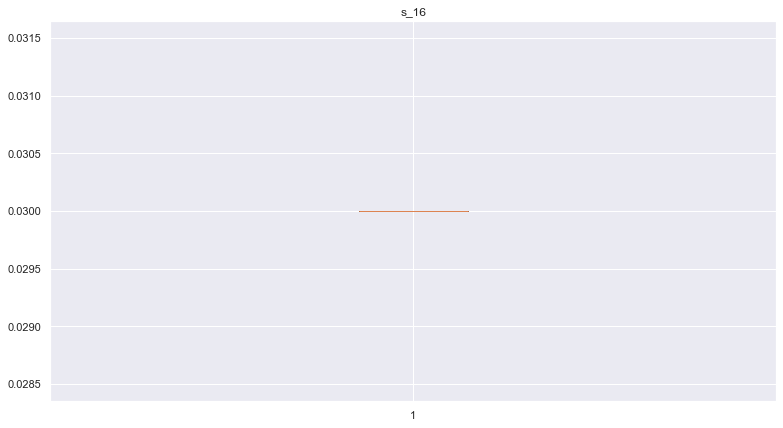

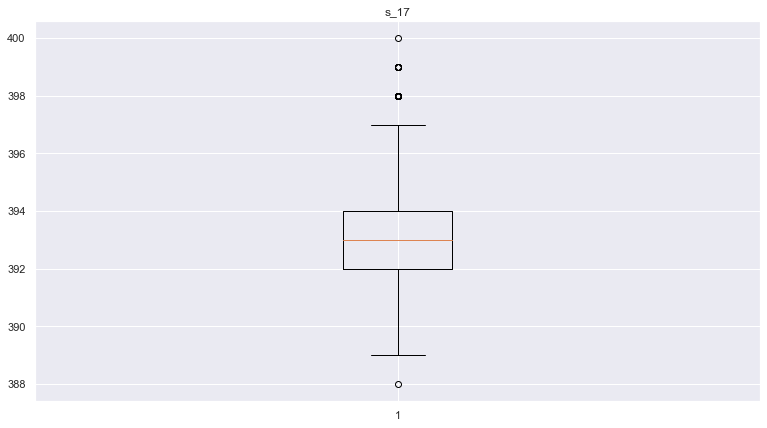

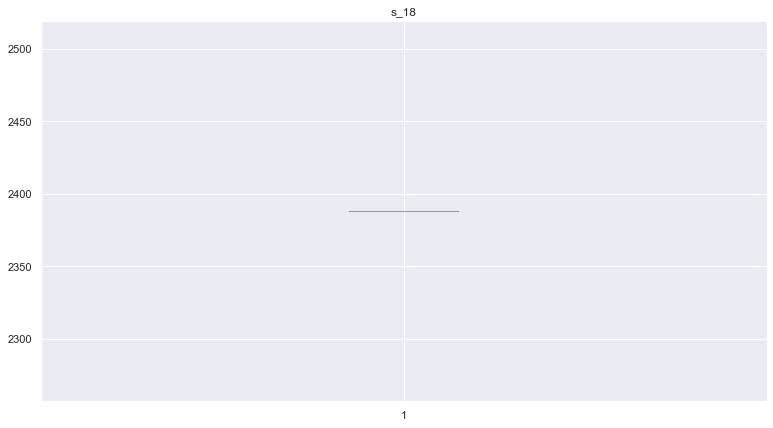

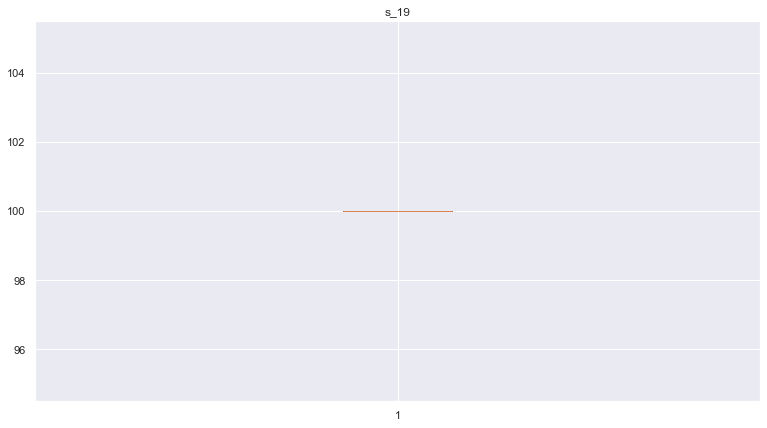

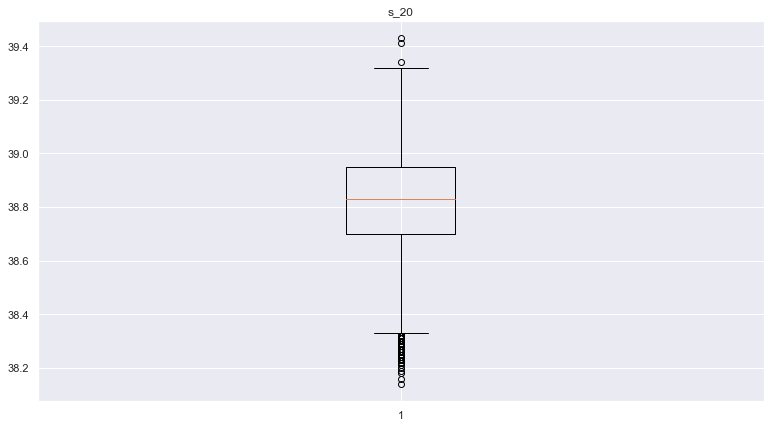

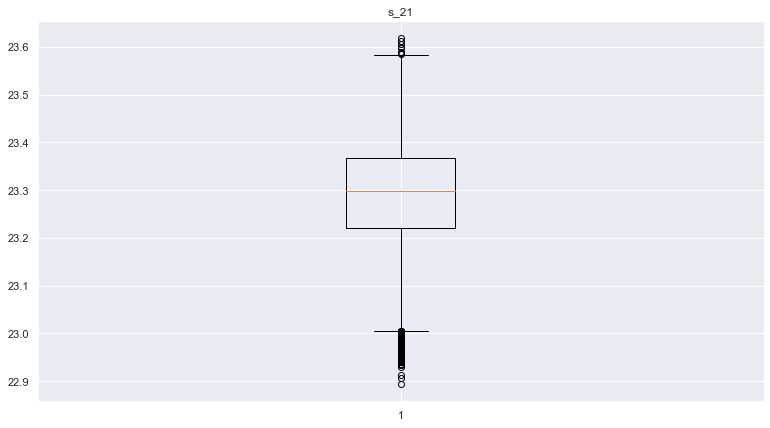

In [17]:
for x in sensor_names:
    plt.figure(figsize=(13,7))
    plt.boxplot(train[x])
    plt.title(x)
    plt.show()

## Max time cycle found for each Unit

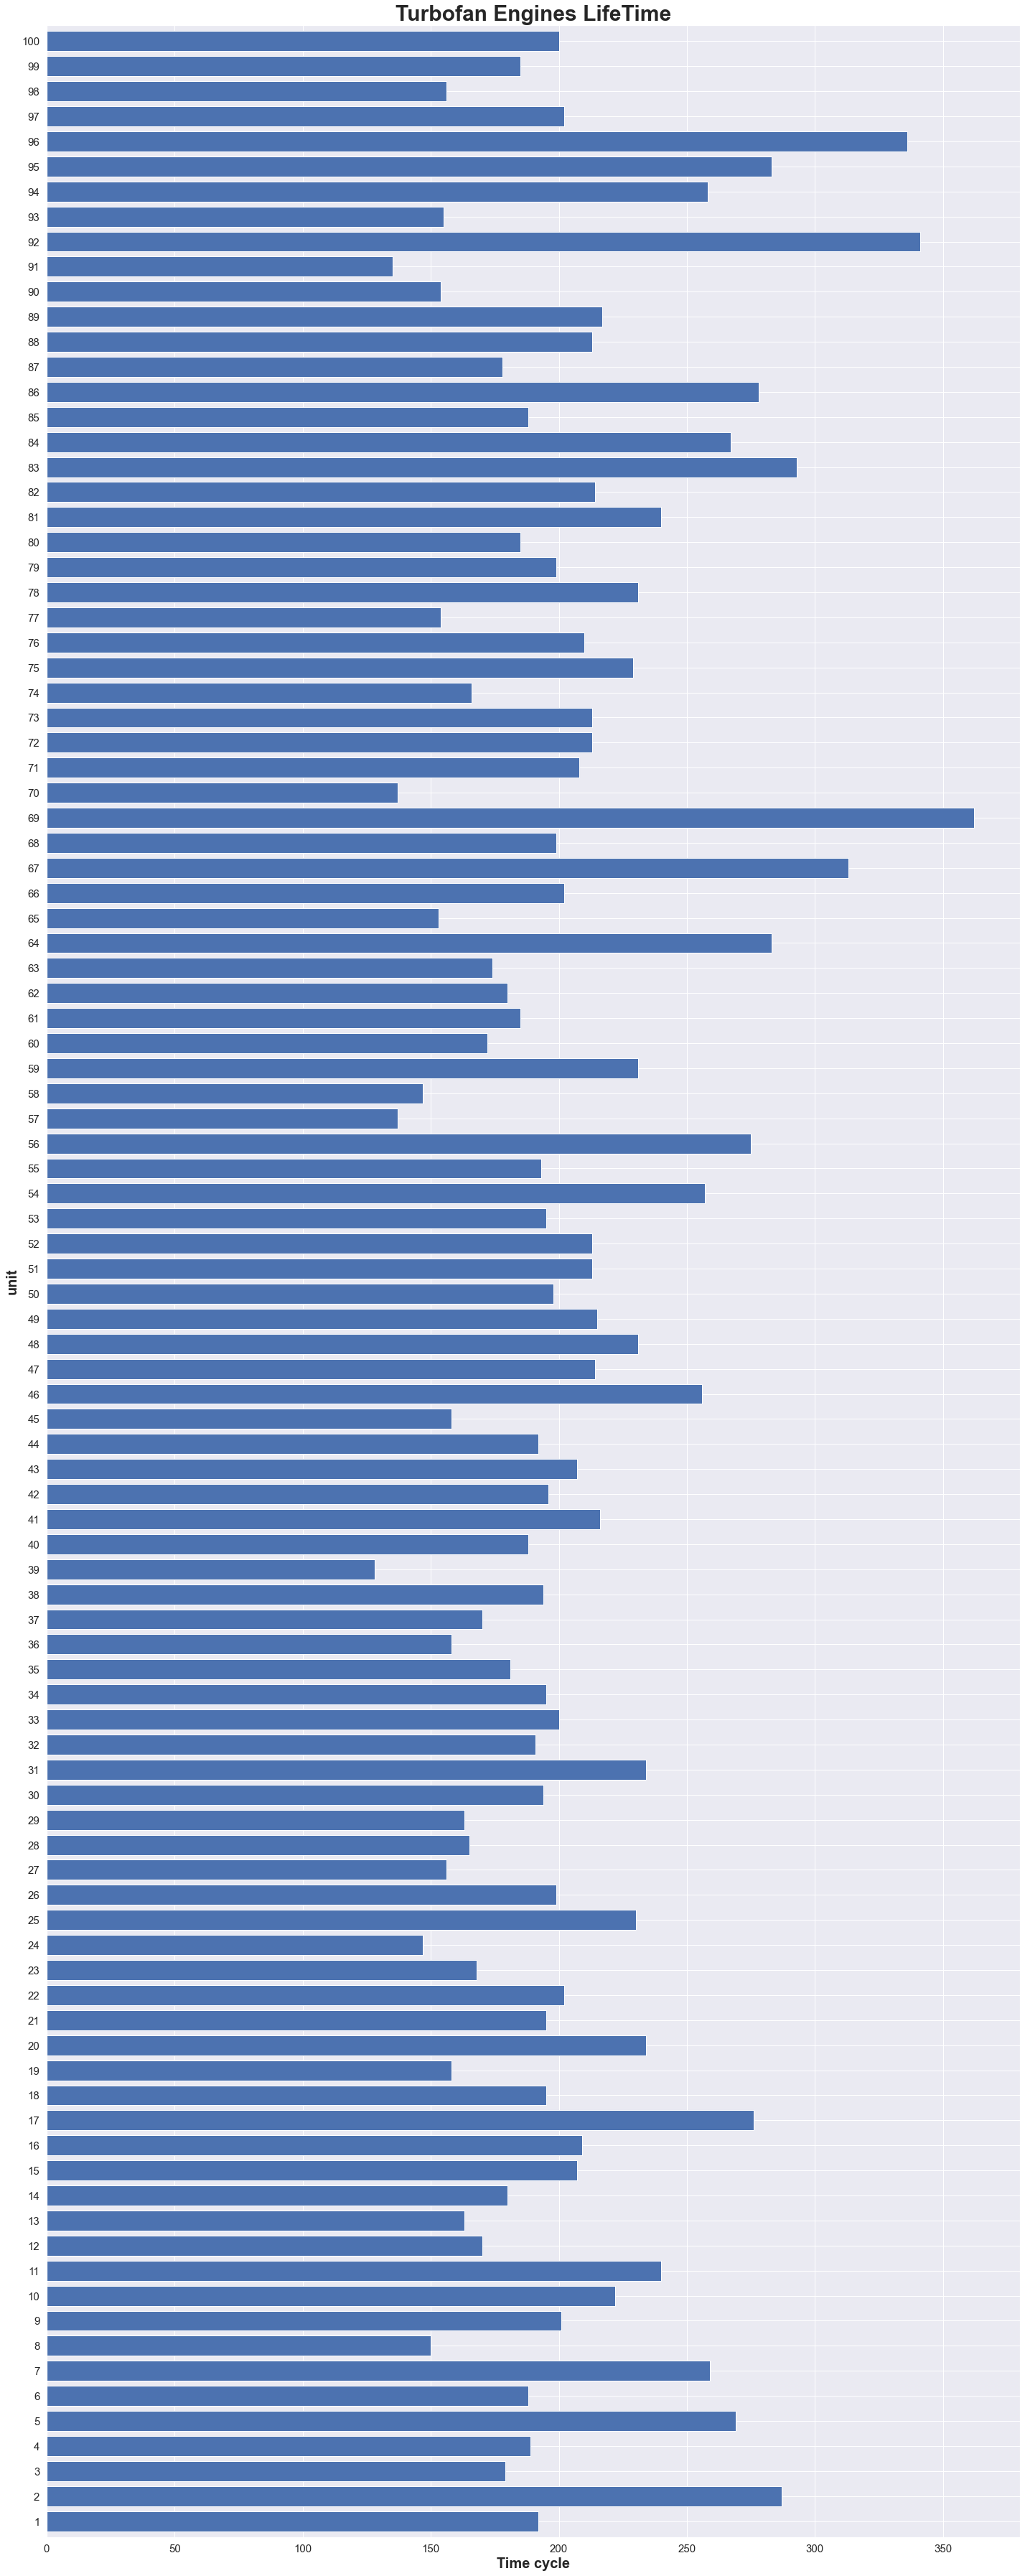

In [18]:
max_time_cycles=train[index_names].groupby('unit_nr').max()
plt.figure(figsize=(20,50))
ax=max_time_cycles['time_cycles'].plot(kind='barh',width=0.8, stacked=True,align='center')
plt.title('Turbofan Engines LifeTime',fontweight='bold',size=30)
plt.xlabel('Time cycle',fontweight='bold',size=20)
plt.xticks(size=15)
plt.ylabel('unit',fontweight='bold',size=20)
plt.yticks(size=15)
plt.grid(True)
plt.tight_layout()
plt.show()

Text(0.5, 8.959999999999994, 'max time cycle')

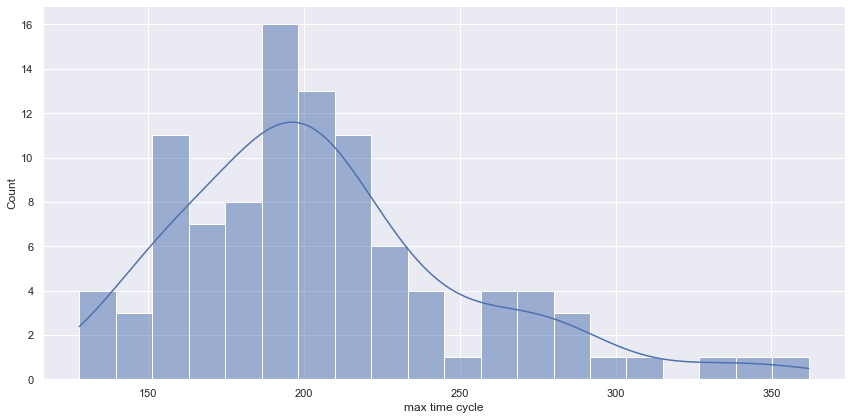

In [19]:
#Distribution of maximum time cycles
sns.displot(max_time_cycles['time_cycles'],kde=True,bins=20,height=6,aspect=2)
plt.xlabel('max time cycle')

## Extraction of only Important Features which have strong relation affecting RUL of engine

In [20]:
# This is done to select only important features for model building in order to avoid problem of " Overfitting".

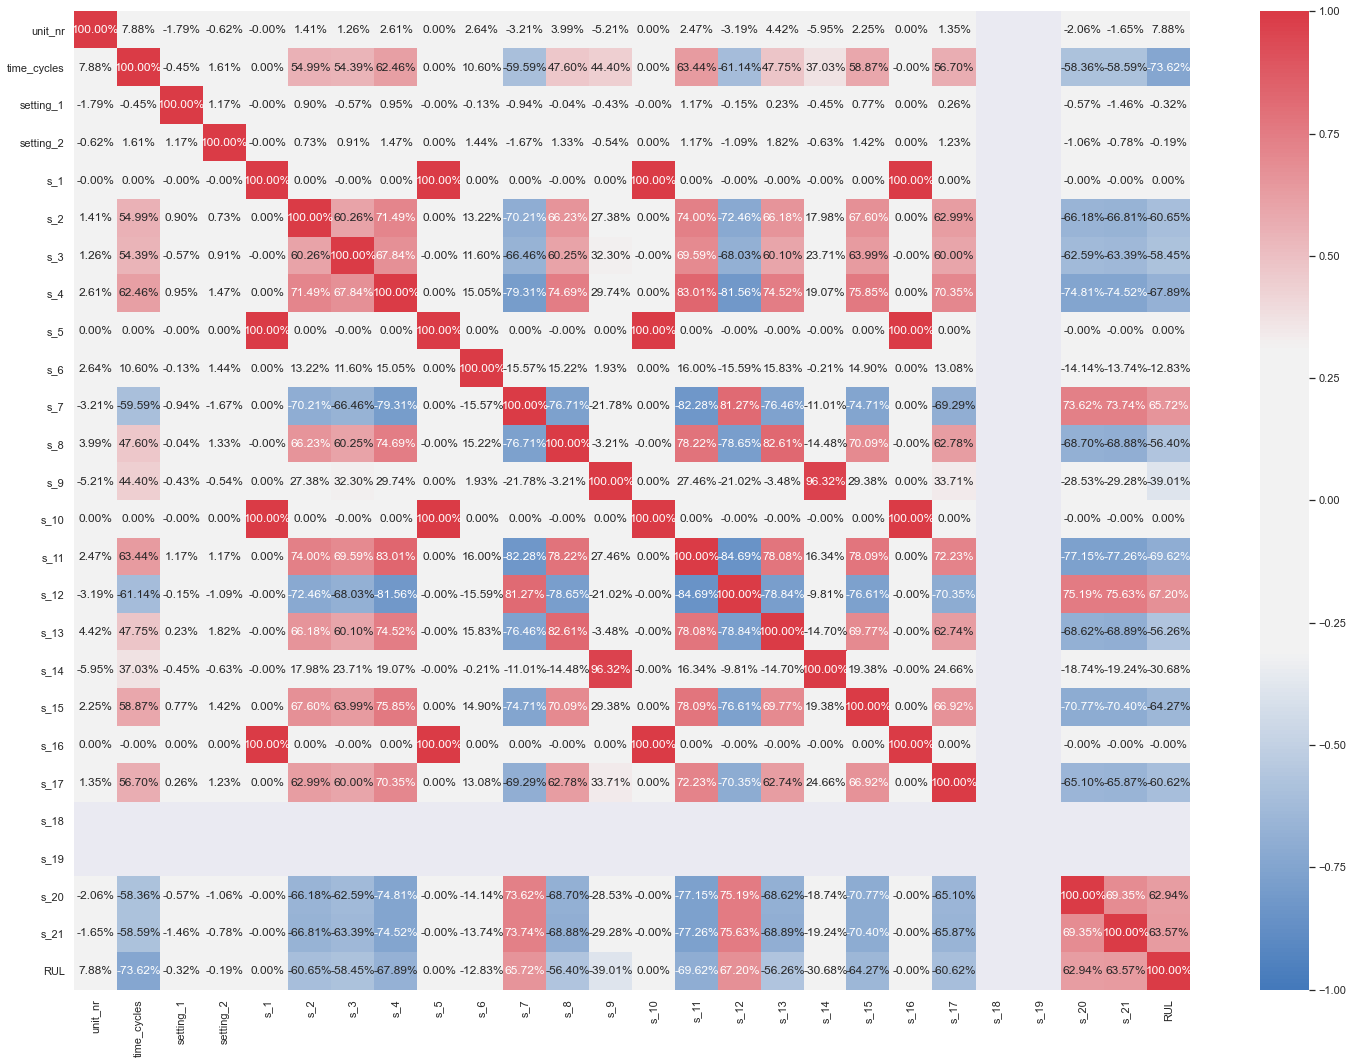

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(25, 18))
correlation_matrix = train.corr()

# Define a custom color map with varying shades
cmap = sns.diverging_palette(250, 10, sep=80, as_cmap=True)

sns.heatmap(correlation_matrix, annot=True, cmap=cmap, fmt='.2%', vmin=-1, vmax=1)
plt.show()


In [22]:
cor=train.corr()
#cor_target = abs(cor["RUL"])
#Selecting highly correlated features
train_relevant_features = cor[abs(cor['RUL'])>=0.5]

train_relevant_features['RUL']

time_cycles   -0.736241
s_2           -0.606484
s_3           -0.584520
s_4           -0.678948
s_7            0.657223
s_8           -0.563968
s_11          -0.696228
s_12           0.671983
s_13          -0.562569
s_15          -0.642667
s_17          -0.606154
s_20           0.629428
s_21           0.635662
RUL            1.000000
Name: RUL, dtype: float64

In [23]:
list_relevant_features=train_relevant_features.index
list_relevant_features=list_relevant_features[1:]
list_relevant_features

Index(['s_2', 's_3', 's_4', 's_7', 's_8', 's_11', 's_12', 's_13', 's_15',
       's_17', 's_20', 's_21', 'RUL'],
      dtype='object')

In [24]:
# Above list contains important features have correlation of magnitude greater and equal to 0.5 with our target variable RUL.

In [25]:
# Now we will keep onlt these imprtant features in both train & test dataset.
train=train[list_relevant_features]

In [26]:
train.head(5)

s_2      s_3      s_4     s_7      s_8   s_11    s_12     s_13    s_15  \
0  641.82  1589.70  1400.60  554.36  2388.06  47.47  521.66  2388.02  8.4195   
1  642.15  1591.82  1403.14  553.75  2388.04  47.49  522.28  2388.07  8.4318   
2  642.35  1587.99  1404.20  554.26  2388.08  47.27  522.42  2388.03  8.4178   
3  642.35  1582.79  1401.87  554.45  2388.11  47.13  522.86  2388.08  8.3682   
4  642.37  1582.85  1406.22  554.00  2388.06  47.28  522.19  2388.04  8.4294   

   s_17   s_20     s_21  RUL  
0   392  39.06  23.4190  191  
1   392  39.00  23.4236  190  
2   390  38.95  23.3442  189  
3   392  38.88  23.3739  188  
4   393  38.90  23.4044  187

array([[<AxesSubplot:title={'center':'s_2'}>,
        <AxesSubplot:title={'center':'s_3'}>,
        <AxesSubplot:title={'center':'s_4'}>],
       [<AxesSubplot:title={'center':'s_7'}>,
        <AxesSubplot:title={'center':'s_8'}>,
        <AxesSubplot:title={'center':'s_11'}>],
       [<AxesSubplot:title={'center':'s_12'}>,
        <AxesSubplot:title={'center':'s_13'}>,
        <AxesSubplot:title={'center':'s_15'}>],
       [<AxesSubplot:title={'center':'s_17'}>,
        <AxesSubplot:title={'center':'s_20'}>,
        <AxesSubplot:title={'center':'s_21'}>]], dtype=object)

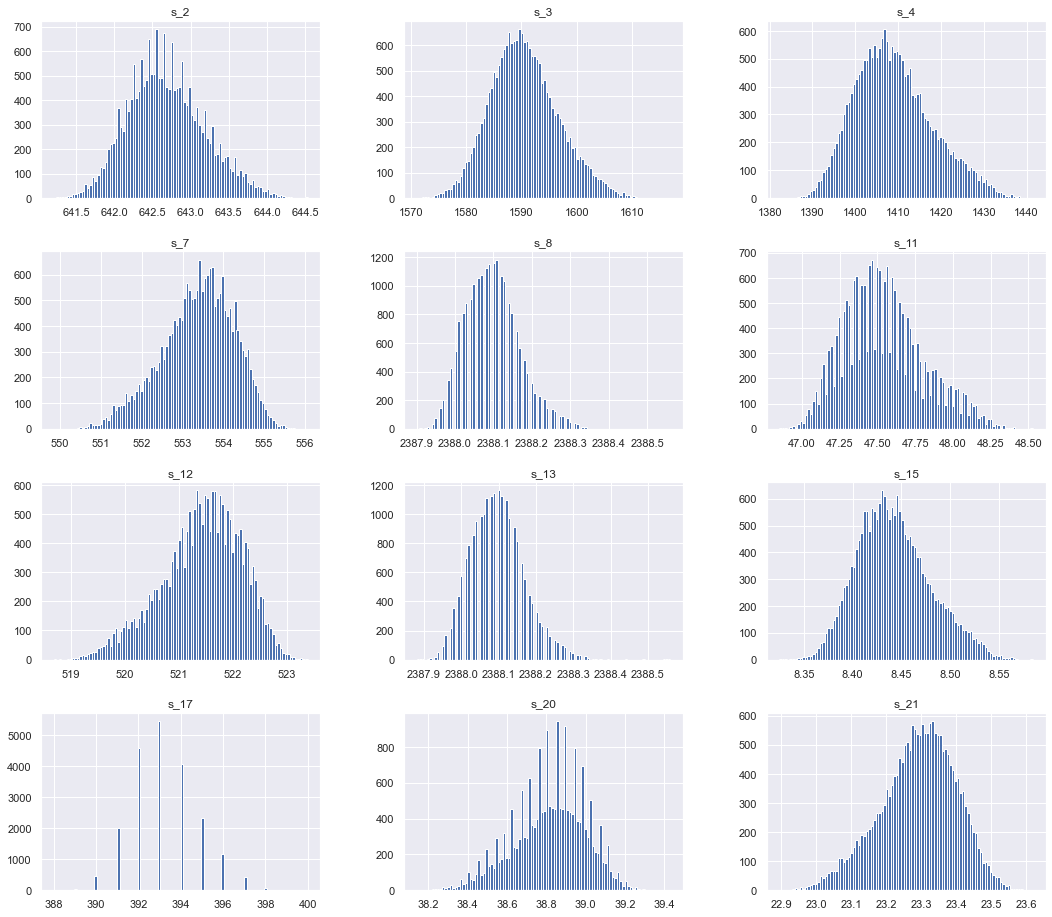

In [27]:
sensor_names=['s_{}'.format(i) for i in range(1,22) if i not in [1,5,6,9,10,14,16,18,19]]
pd.DataFrame(train,columns=['s_{}'.format(i) for i in range(1,22)])[sensor_names].hist(bins=100, figsize=(18,16))

## Seperating Train & Test Data

In [28]:
# train & y_train
# Calculated RUL variable is our Target variable.
y_train=train['RUL']
X_train=train.drop(['RUL'],axis=1)
X_train.head(5)

s_2      s_3      s_4     s_7      s_8   s_11    s_12     s_13    s_15  \
0  641.82  1589.70  1400.60  554.36  2388.06  47.47  521.66  2388.02  8.4195   
1  642.15  1591.82  1403.14  553.75  2388.04  47.49  522.28  2388.07  8.4318   
2  642.35  1587.99  1404.20  554.26  2388.08  47.27  522.42  2388.03  8.4178   
3  642.35  1582.79  1401.87  554.45  2388.11  47.13  522.86  2388.08  8.3682   
4  642.37  1582.85  1406.22  554.00  2388.06  47.28  522.19  2388.04  8.4294   

   s_17   s_20     s_21  
0   392  39.06  23.4190  
1   392  39.00  23.4236  
2   390  38.95  23.3442  
3   392  38.88  23.3739  
4   393  38.90  23.4044

In [29]:
test.head(5)

setting_1  setting_2  setting_3     s_1     s_2      s_3      s_4    s_5  \
0    -0.0006     0.0004      100.0  518.67  642.58  1581.22  1398.91  14.62   
1     0.0018    -0.0001      100.0  518.67  642.55  1586.59  1410.83  14.62   
2    -0.0016     0.0004      100.0  518.67  642.88  1589.75  1418.89  14.62   
3     0.0012     0.0004      100.0  518.67  642.78  1594.53  1406.88  14.62   
4    -0.0013    -0.0004      100.0  518.67  642.27  1589.94  1419.36  14.62   

     s_6     s_7  ...    s_12     s_13     s_14    s_15  s_16  s_17  s_18  \
0  21.61  554.42  ...  521.79  2388.06  8130.11  8.4024  0.03   393  2388   
1  21.61  553.52  ...  521.74  2388.09  8126.90  8.4505  0.03   391  2388   
2  21.61  552.59  ...  520.83  2388.14  8131.46  8.4119  0.03   395  2388   
3  21.61  552.64  ...  521.88  2388.11  8133.64  8.4634  0.03   395  2388   
4  21.61  553.29  ...  521.00  2388.15  8125.74  8.4362  0.03   394  2388   

    s_19   s_20     s_21  
0  100.0  38.81  23.3552  
1  100.0  38.81  23.2618  
2  100.0  38.93  23.2740  
3  100.0  38.58  23.2581  
4  100.0  38.75  23.4117  

[5 rows x 24 columns]

In [30]:
# Test data set , keeping only train columns/features.
X_test=test[X_train.columns]
X_test.head(5)

s_2      s_3      s_4     s_7      s_8   s_11    s_12     s_13    s_15  \
0  642.58  1581.22  1398.91  554.42  2388.08  47.23  521.79  2388.06  8.4024   
1  642.55  1586.59  1410.83  553.52  2388.10  47.67  521.74  2388.09  8.4505   
2  642.88  1589.75  1418.89  552.59  2388.16  47.88  520.83  2388.14  8.4119   
3  642.78  1594.53  1406.88  552.64  2388.13  47.65  521.88  2388.11  8.4634   
4  642.27  1589.94  1419.36  553.29  2388.10  47.46  521.00  2388.15  8.4362   

   s_17   s_20     s_21  
0   393  38.81  23.3552  
1   391  38.81  23.2618  
2   395  38.93  23.2740  
3   395  38.58  23.2581  
4   394  38.75  23.4117

In [31]:
y_test.head(5)

RUL
0  112
1   98
2   69
3   82
4   91

In [32]:
y_train.describe()

count    20631.000000
mean       107.807862
std         68.880990
min          0.000000
25%         51.000000
50%        103.000000
75%        155.000000
max        361.000000
Name: RUL, dtype: float64

In [33]:
# Clipping of RUL at 103 ,as RUL is left skewed in the dataset.
# This is done to improve performance of the applied models.

y_train= y_train.clip(upper=103)
y_train.head(5)

0    103
1    103
2    103
3    103
4    103
Name: RUL, dtype: int64

In [34]:
y_test.describe()

RUL
count  100.00000
mean    75.52000
std     41.76497
min      7.00000
25%     32.75000
50%     86.00000
75%    112.25000
max    145.00000

In [35]:
y_test= y_test.clip(upper=103)
y_test.head(5)

RUL
0  103
1   98
2   69
3   82
4   91

## Building Model

In [36]:
# first create an evaluate function
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))
    return rmse,variance;

## Bi-LSTM model

In [37]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

In [38]:
# Model 8: Bidirectional LSTM
def build_bilstm_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=input_shape))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [39]:
# Preprocess data for LSTM
scaler_lstm = StandardScaler()
X_train_lstm = scaler_lstm.fit_transform(X_train)
X_test_lstm = scaler_lstm.transform(X_test)

In [40]:
# Reshape input for LSTM (assuming your data is sequential)
X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], 1, X_train_lstm.shape[1]))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], 1, X_test_lstm.shape[1]))


In [41]:
# Build and train the Bidirectional LSTM model
input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])
bilstm_model = build_bilstm_model(input_shape)


In [42]:
# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



In [43]:
# Train the model
bilstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/50
516/516 [==============================] - 6s 4ms/step - loss: 4238.1299 - mae: 55.6359 - val_loss: 2265.4636 - val_mae: 38.4181
Epoch 2/50
516/516 [==============================] - 1s 2ms/step - loss: 1553.7699 - mae: 31.0495 - val_loss: 781.2928 - val_mae: 22.0535
Epoch 3/50
516/516 [==============================] - 1s 2ms/step - loss: 506.3493 - mae: 17.5909 - val_loss: 332.1701 - val_mae: 14.1732
Epoch 4/50
516/516 [==============================] - 1s 2ms/step - loss: 268.4857 - mae: 12.5151 - val_loss: 251.8533 - val_mae: 11.7039
Epoch 5/50
516/516 [==============================] - 1s 2ms/step - loss: 241.2709 - mae: 11.4116 - val_loss: 247.3822 - val_mae: 11.2723
Epoch 6/50
516/516 [==============================] - 1s 2ms/step - loss: 237.4786 - mae: 11.1861 - val_loss: 242.7209 - val_mae: 11.2794
Epoch 7/50
516/516 [==============================] - 1s 2ms/step - loss: 234.6518 - mae: 11.0719 - val_loss: 240.3647 - val_mae: 11.0511
Epoch 8/50
516/516 [===========

In [44]:
# Evaluate on train data
y_hat_train_lstm = bilstm_model.predict(X_train_lstm)
RMSE_Train_LSTM, R2_Train_LSTM = evaluate(y_train, y_hat_train_lstm, 'train')

645/645 [==============================] - 1s 2ms/step
train set RMSE:14.971240504037858, R2:0.7993993053793699


In [45]:
# Evaluate on test data
y_hat_test_lstm = bilstm_model.predict(X_test_lstm)
RMSE_Test_LSTM, R2_Test_LSTM = evaluate(y_test, y_hat_test_lstm, 'test')


4/4 [==============================] - 0s 3ms/step
test set RMSE:14.860500103567857, R2:0.8205242220938074


In [46]:
# Make Dataframe which will contain results of all applied Model
Results=pd.DataFrame({'Model': ['BiLSTM'],
    'RMSE-Train': [RMSE_Train_LSTM],
    'R2-Train': [R2_Train_LSTM],
    'RMSE-Test': [RMSE_Test_LSTM],
    'R2-Test': [R2_Test_LSTM]})
Results

Model  RMSE-Train  R2-Train  RMSE-Test   R2-Test
0  BiLSTM   14.971241  0.799399    14.8605  0.820524

## Bi-TRNN model

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, SimpleRNN, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Model: Bidirectional TRNN (replace with your desired function name)
def Bi_trnn(input_shape):
    model = Sequential()
    model.add(Bidirectional(SimpleRNN(50, activation='relu'), input_shape=input_shape))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


In [48]:
# Preprocess data for Bi-TRNN
scaler_bi_trnn = StandardScaler()
X_train_bi_trnn = scaler_bi_trnn.fit_transform(X_train)
X_test_bi_trnn = scaler_bi_trnn.transform(X_test)

In [49]:
# Reshape input for Bi-TRNN (assuming your data is sequential)
X_train_bi_trnn = X_train_bi_trnn.reshape((X_train_bi_trnn.shape[0], X_train_bi_trnn.shape[1], 1))
X_test_bi_trnn = X_test_bi_trnn.reshape((X_test_bi_trnn.shape[0], X_test_bi_trnn.shape[1], 1))


In [50]:
# Build and train the Bidirectional TRNN model
input_shape_bi_trnn = (X_train_bi_trnn.shape[1], X_train_bi_trnn.shape[2])
bi_trnn_model = Bi_trnn(input_shape_bi_trnn)

# Define early stopping to prevent overfitting
early_stopping_bi_trnn = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [51]:
# Train the model
bi_trnn_model.fit(X_train_bi_trnn, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping_bi_trnn])


Epoch 1/50
516/516 [==============================] - 4s 4ms/step - loss: 809.3002 - mae: 19.1861 - val_loss: 260.5303 - val_mae: 11.2933
Epoch 2/50
516/516 [==============================] - 2s 4ms/step - loss: 259.4134 - mae: 12.0900 - val_loss: 246.9059 - val_mae: 11.2046
Epoch 3/50
516/516 [==============================] - 2s 5ms/step - loss: 252.8879 - mae: 11.8046 - val_loss: 263.4039 - val_mae: 11.4330
Epoch 4/50
516/516 [==============================] - 2s 5ms/step - loss: 254.5089 - mae: 11.8575 - val_loss: 340.9058 - val_mae: 15.3661
Epoch 5/50
516/516 [==============================] - 2s 4ms/step - loss: 248.5052 - mae: 11.6684 - val_loss: 247.1438 - val_mae: 11.6136
Epoch 6/50
516/516 [==============================] - 2s 5ms/step - loss: 240.2597 - mae: 11.3687 - val_loss: 255.7065 - val_mae: 11.1442
Epoch 7/50
516/516 [==============================] - 2s 5ms/step - loss: 244.0884 - mae: 11.5132 - val_loss: 240.0618 - val_mae: 10.5953
Epoch 8/50
516/516 [==============

In [52]:
# Evaluate on train data
y_hat_train_bi_trnn = bi_trnn_model.predict(X_train_bi_trnn)
RMSE_Train_BiTRNN, R2_Train_BiTRNN = evaluate(y_train, y_hat_train_bi_trnn, 'train')



645/645 [==============================] - 2s 2ms/step
train set RMSE:15.063579245262595, R2:0.7969171678667359


In [53]:
# Evaluate on test data
y_hat_test_bi_trnn = bi_trnn_model.predict(X_test_bi_trnn)
RMSE_Test_BiTRNN, R2_Test_BiTRNN = evaluate(y_test, y_hat_test_bi_trnn, 'test')


4/4 [==============================] - 0s 2ms/step
test set RMSE:15.009128550100224, R2:0.8169161869743078


In [54]:
# Add results to the DataFrame
Results = Results.append(pd.DataFrame({
    'Model': ['BiTRNN'],
    'RMSE-Train': [RMSE_Train_BiTRNN],
    'R2-Train': [R2_Train_BiTRNN],
    'RMSE-Test': [RMSE_Test_BiTRNN],
    'R2-Test': [R2_Test_BiTRNN]
}), ignore_index=True)

# Display the results DataFrame
Results


Model  RMSE-Train  R2-Train  RMSE-Test   R2-Test
0  BiLSTM   14.971241  0.799399  14.860500  0.820524
1  BiTRNN   15.063579  0.796917  15.009129  0.816916

## Bi-GRU model

In [55]:
# Import necessary libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Bidirectional, GRU
from tensorflow.keras.callbacks import EarlyStopping


In [56]:
# Model: Bidirectional GRU (Bi-GRU)
def build_bi_gru_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(GRU(50, activation='relu'), input_shape=input_shape))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [57]:
# Preprocess data for GRU
scaler_bi_gru = StandardScaler()
X_train_bi_gru = scaler_bi_gru.fit_transform(X_train)
X_test_bi_gru = scaler_bi_gru.transform(X_test)


In [58]:
# Reshape input for GRU (assuming your data is sequential)
X_train_bi_gru = X_train_bi_gru.reshape((X_train_bi_gru.shape[0], 1, X_train_bi_gru.shape[1]))
X_test_bi_gru = X_test_bi_gru.reshape((X_test_bi_gru.shape[0], 1, X_test_bi_gru.shape[1]))


In [59]:
# Build and train the Bidirectional GRU model
input_shape_bi_gru = (X_train_bi_gru.shape[1], X_train_bi_gru.shape[2])
bi_gru_model = build_bi_gru_model(input_shape_bi_gru)


In [60]:
# Define early stopping to prevent overfitting
early_stopping_bi_gru = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [61]:
# Train the model
bi_gru_model.fit(X_train_bi_gru, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping_bi_gru])


Epoch 1/50
516/516 [==============================] - 4s 3ms/step - loss: 3569.3296 - mae: 50.1743 - val_loss: 1319.7991 - val_mae: 29.1808
Epoch 2/50
516/516 [==============================] - 1s 3ms/step - loss: 553.2040 - mae: 17.8869 - val_loss: 262.2057 - val_mae: 12.2742
Epoch 3/50
516/516 [==============================] - 1s 3ms/step - loss: 240.3217 - mae: 11.5672 - val_loss: 244.2231 - val_mae: 11.3633
Epoch 4/50
516/516 [==============================] - 1s 2ms/step - loss: 234.2966 - mae: 11.1823 - val_loss: 243.6968 - val_mae: 11.1914
Epoch 5/50
516/516 [==============================] - 1s 3ms/step - loss: 231.8307 - mae: 11.0390 - val_loss: 238.3661 - val_mae: 10.9838
Epoch 6/50
516/516 [==============================] - 1s 3ms/step - loss: 229.4073 - mae: 10.8882 - val_loss: 238.4717 - val_mae: 11.0648
Epoch 7/50
516/516 [==============================] - 1s 2ms/step - loss: 227.5071 - mae: 10.7927 - val_loss: 236.0081 - val_mae: 11.1500
Epoch 8/50
516/516 [============

In [62]:
# Evaluate on train data
y_hat_train_bi_gru = bi_gru_model.predict(X_train_bi_gru)
RMSE_Train_BiGRU, R2_Train_BiGRU = evaluate(y_train, y_hat_train_bi_gru, 'train')


645/645 [==============================] - 1s 2ms/step
train set RMSE:14.961377121008216, R2:0.7996635386222197


In [63]:
# Evaluate on test data
y_hat_test_bi_gru = bi_gru_model.predict(X_test_bi_gru)
RMSE_Test_BiGRU, R2_Test_BiGRU = evaluate(y_test, y_hat_test_bi_gru, 'test')


4/4 [==============================] - 0s 0s/step
test set RMSE:14.802107494180392, R2:0.8219319094305074


In [64]:
# Add results to the DataFrame
Results = Results.append(pd.DataFrame({
    'Model': ['BiGRU'],
    'RMSE-Train': [RMSE_Train_BiGRU],
    'R2-Train': [R2_Train_BiGRU],
    'RMSE-Test': [RMSE_Test_BiGRU],
    'R2-Test': [R2_Test_BiGRU]
}), ignore_index=True)


In [65]:
# Display the results DataFrame
Results


Model  RMSE-Train  R2-Train  RMSE-Test   R2-Test
0  BiLSTM   14.971241  0.799399  14.860500  0.820524
1  BiTRNN   15.063579  0.796917  15.009129  0.816916
2   BiGRU   14.961377  0.799664  14.802107  0.821932

## ProgNet model

In [66]:
# Import necessary libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Bidirectional, GRU
from tensorflow.keras.callbacks import EarlyStopping


In [67]:
from tensorflow.keras.layers import LSTM

# Model: ProgNet (Progressive Neural Network) with LSTM layers
def build_prognet_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model



In [68]:
# Preprocess data for ProgNet
scaler_prognet = StandardScaler()
X_train_prognet = scaler_prognet.fit_transform(X_train)
X_test_prognet = scaler_prognet.transform(X_test)


In [69]:
# Reshape input for LSTM (assuming your data is sequential)
X_train_prognet = X_train_prognet.reshape((X_train_prognet.shape[0], X_train_prognet.shape[1], 1))

# Build and train the ProgNet model
input_shape_prognet = (X_train_prognet.shape[1], X_train_prognet.shape[2])
prognet_model = build_prognet_model(input_shape_prognet)


In [70]:
# Define early stopping to prevent overfitting
early_stopping_prognet = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [71]:
# Train the model
prognet_model.fit(X_train_prognet, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping_prognet])


Epoch 1/50
516/516 [==============================] - 7s 9ms/step - loss: 906.4828 - mae: 20.6835 - val_loss: 327.6530 - val_mae: 14.7042
Epoch 2/50
516/516 [==============================] - 4s 8ms/step - loss: 327.2295 - mae: 13.6782 - val_loss: 292.7643 - val_mae: 12.8080
Epoch 3/50
516/516 [==============================] - 4s 8ms/step - loss: 307.9008 - mae: 13.3611 - val_loss: 271.2379 - val_mae: 12.2841
Epoch 4/50
516/516 [==============================] - 4s 8ms/step - loss: 278.8771 - mae: 12.6008 - val_loss: 255.2451 - val_mae: 11.7127
Epoch 5/50
516/516 [==============================] - 4s 8ms/step - loss: 263.6049 - mae: 12.1059 - val_loss: 271.6825 - val_mae: 11.5163
Epoch 6/50
516/516 [==============================] - 4s 8ms/step - loss: 260.2868 - mae: 11.9895 - val_loss: 258.2318 - val_mae: 10.7344
Epoch 7/50
516/516 [==============================] - 4s 8ms/step - loss: 258.1468 - mae: 11.8831 - val_loss: 276.2919 - val_mae: 13.5755
Epoch 8/50
516/516 [==============

In [72]:
# Evaluate on train data
y_hat_train_prognet = prognet_model.predict(X_train_prognet)
RMSE_Train_ProgNet, R2_Train_ProgNet = evaluate(y_train, y_hat_train_prognet, 'train')


645/645 [==============================] - 2s 3ms/step
train set RMSE:15.923957804153483, R2:0.7730559010884693


In [73]:
# Reshape input for LSTM (assuming your data is sequential)
X_test_prognet = X_test_prognet.reshape((X_test_prognet.shape[0], X_test_prognet.shape[1], 1))

# Evaluate on test data
y_hat_test_prognet = prognet_model.predict(X_test_prognet)

# Now you can proceed with the evaluation
RMSE_Test_ProgNet, R2_Test_ProgNet = evaluate(y_test, y_hat_test_prognet, 'test')


4/4 [==============================] - 0s 2ms/step
test set RMSE:15.76869032816058, R2:0.7979167847824512


In [74]:
# Add results to the DataFrame
Results = Results.append(pd.DataFrame({
    'Model': ['ProgNet'],
    'RMSE-Train': [RMSE_Train_ProgNet],
    'R2-Train': [R2_Train_ProgNet],
    'RMSE-Test': [RMSE_Test_ProgNet],
    'R2-Test': [R2_Test_ProgNet]
}), ignore_index=True)

In [75]:
# Display the results DataFrame
Results


Model  RMSE-Train  R2-Train  RMSE-Test   R2-Test
0   BiLSTM   14.971241  0.799399  14.860500  0.820524
1   BiTRNN   15.063579  0.796917  15.009129  0.816916
2    BiGRU   14.961377  0.799664  14.802107  0.821932
3  ProgNet   15.923958  0.773056  15.768690  0.797917

## DCNN model

In [76]:
# Import necessary libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Bidirectional, GRU, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping

In [77]:
# Model: Deep Convolutional Neural Network (DCNN)
def build_dcnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [78]:
# Preprocess data for DCNN
scaler_dcnn = StandardScaler()
X_train_dcnn = scaler_dcnn.fit_transform(X_train)
X_test_dcnn = scaler_dcnn.transform(X_test)

In [79]:
# Reshape input for DCNN (assuming your data is sequential)
X_train_dcnn = X_train_dcnn.reshape((X_train_dcnn.shape[0], X_train_dcnn.shape[1], 1))
X_test_dcnn = X_test_dcnn.reshape((X_test_dcnn.shape[0], X_test_dcnn.shape[1], 1))


In [80]:
# Build and train the DCNN model
input_shape_dcnn = (X_train_dcnn.shape[1], X_train_dcnn.shape[2])
dcnn_model = build_dcnn_model(input_shape_dcnn)

In [81]:
# Define early stopping to prevent overfitting
early_stopping_dcnn = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [82]:
# Train the model
dcnn_model.fit(X_train_dcnn, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping_dcnn])


Epoch 1/50
516/516 [==============================] - 2s 2ms/step - loss: 1407.0308 - mae: 27.8368 - val_loss: 315.9788 - val_mae: 13.6922
Epoch 2/50
516/516 [==============================] - 1s 2ms/step - loss: 299.2591 - mae: 13.2767 - val_loss: 273.7677 - val_mae: 12.0647
Epoch 3/50
516/516 [==============================] - 1s 2ms/step - loss: 278.0717 - mae: 12.5615 - val_loss: 265.9988 - val_mae: 12.3598
Epoch 4/50
516/516 [==============================] - 1s 2ms/step - loss: 268.5197 - mae: 12.2578 - val_loss: 258.2859 - val_mae: 11.5963
Epoch 5/50
516/516 [==============================] - 1s 3ms/step - loss: 264.5637 - mae: 12.0975 - val_loss: 255.0695 - val_mae: 11.8460
Epoch 6/50
516/516 [==============================] - 2s 3ms/step - loss: 261.3839 - mae: 12.0058 - val_loss: 254.9079 - val_mae: 11.6733
Epoch 7/50
516/516 [==============================] - 2s 3ms/step - loss: 259.7999 - mae: 11.9580 - val_loss: 252.1170 - val_mae: 11.6498
Epoch 8/50
516/516 [=============

In [83]:
# Evaluate on train data
y_hat_train_dcnn = dcnn_model.predict(X_train_dcnn)
RMSE_Train_DCNN, R2_Train_DCNN = evaluate(y_train, y_hat_train_dcnn, 'train')


645/645 [==============================] - 1s 2ms/step
train set RMSE:15.416912876368531, R2:0.7872783492126456


In [84]:
# Evaluate on test data
y_hat_test_dcnn = dcnn_model.predict(X_test_dcnn)
RMSE_Test_DCNN, R2_Test_DCNN = evaluate(y_test, y_hat_test_dcnn, 'test')


4/4 [==============================] - 0s 5ms/step
test set RMSE:15.308773811381167, R2:0.8095329712454212


In [85]:
# Add results to the DataFrame
Results = Results.append(pd.DataFrame({
    'Model': ['DCNN'],
    'RMSE-Train': [RMSE_Train_DCNN],
    'R2-Train': [R2_Train_DCNN],
    'RMSE-Test': [RMSE_Test_DCNN],
    'R2-Test': [R2_Test_DCNN]
}), ignore_index=True)

In [86]:
# Display the results DataFrame
Results


Model  RMSE-Train  R2-Train  RMSE-Test   R2-Test
0   BiLSTM   14.971241  0.799399  14.860500  0.820524
1   BiTRNN   15.063579  0.796917  15.009129  0.816916
2    BiGRU   14.961377  0.799664  14.802107  0.821932
3  ProgNet   15.923958  0.773056  15.768690  0.797917
4     DCNN   15.416913  0.787278  15.308774  0.809533

## Individual model result

In [87]:
# Display the results DataFrame
Results


Model  RMSE-Train  R2-Train  RMSE-Test   R2-Test
0   BiLSTM   14.971241  0.799399  14.860500  0.820524
1   BiTRNN   15.063579  0.796917  15.009129  0.816916
2    BiGRU   14.961377  0.799664  14.802107  0.821932
3  ProgNet   15.923958  0.773056  15.768690  0.797917
4     DCNN   15.416913  0.787278  15.308774  0.809533

## Ensemble model using RDT(Regression Decision Tree)

In [88]:
# Concatenate predictions from all base learners for training data
X_train_ensemble = np.concatenate((y_hat_train_bi_trnn, y_hat_train_lstm, y_hat_train_bi_gru, y_hat_train_dcnn, y_hat_train_prognet), axis=1)

# Concatenate predictions from all base learners for test data
X_test_ensemble = np.concatenate((y_hat_test_bi_trnn, y_hat_test_lstm,y_hat_test_bi_gru,y_hat_test_dcnn, y_hat_test_prognet), axis=1)


In [89]:
# Model : Regression Decision Tree (RDT)
rdt_model = DecisionTreeRegressor()

# Train the RDT model
rdt_model.fit(X_train_ensemble, y_train)


DecisionTreeRegressor()

In [90]:
# Predictions on training data
y_hat_train_ensemble = rdt_model.predict(X_train_ensemble)
RMSE_Train_Ensemble, R2_Train_Ensemble = evaluate(y_train, y_hat_train_ensemble, 'train')

# Predictions on test data
y_hat_test_ensemble = rdt_model.predict(X_test_ensemble)
RMSE_Test_Ensemble, R2_Test_Ensemble = evaluate(y_test, y_hat_test_ensemble, 'test')


train set RMSE:0.0, R2:1.0
test set RMSE:21.069646413739363, R2:0.6392108329237243


In [91]:
# Add results to the DataFrame
Results = Results.append(pd.DataFrame({
    'Model': ['Ensemble (Bi-LSTM + Bi-TRNN + Bi-GRU + DCNN + ProgNet )'],
    'RMSE-Train': [RMSE_Train_Ensemble],
    'R2-Train': [R2_Train_Ensemble],
    'RMSE-Test': [RMSE_Test_Ensemble],
    'R2-Test': [R2_Test_Ensemble]
}), ignore_index=True)

# Display the results DataFrame
Results


Model  RMSE-Train  R2-Train  \
0                                             BiLSTM   14.971241  0.799399   
1                                             BiTRNN   15.063579  0.796917   
2                                              BiGRU   14.961377  0.799664   
3                                            ProgNet   15.923958  0.773056   
4                                               DCNN   15.416913  0.787278   
5  Ensemble (Bi-LSTM + Bi-TRNN + Bi-GRU + DCNN + ...    0.000000  1.000000   

   RMSE-Test   R2-Test  
0  14.860500  0.820524  
1  15.009129  0.816916  
2  14.802107  0.821932  
3  15.768690  0.797917  
4  15.308774  0.809533  
5  21.069646  0.639211

## Ensemble model using Random Forest Regressor

In [92]:
# Model : Random Forest 
random_forest_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)


In [93]:
# Train the Random Forest model
random_forest_model.fit(X_train_ensemble, y_train)


RandomForestRegressor(max_depth=10, random_state=42)

In [94]:
# Predictions on training data
y_hat_train_rf = random_forest_model.predict(X_train_ensemble)
RMSE_Train_RF, R2_Train_RF = evaluate(y_train, y_hat_train_rf, 'train')

# Predictions on test data
y_hat_test_rf = random_forest_model.predict(X_test_ensemble)
RMSE_Test_RF, R2_Test_RF = evaluate(y_test, y_hat_test_rf, 'test')


train set RMSE:13.150282731419681, R2:0.8452299086741005
test set RMSE:14.49649030185365, R2:0.8292090977160258


In [95]:
# Add results to the DataFrame
Results = Results.append(pd.DataFrame({
    'Model': ['Random Forest (Ensemble)'],
    'RMSE-Train': [RMSE_Train_RF],
    'R2-Train': [R2_Train_RF],
    'RMSE-Test': [RMSE_Test_RF],
    'R2-Test': [R2_Test_RF]
}), ignore_index=True)

# Display the results DataFrame
Results


Model  RMSE-Train  R2-Train  \
0                                             BiLSTM   14.971241  0.799399   
1                                             BiTRNN   15.063579  0.796917   
2                                              BiGRU   14.961377  0.799664   
3                                            ProgNet   15.923958  0.773056   
4                                               DCNN   15.416913  0.787278   
5  Ensemble (Bi-LSTM + Bi-TRNN + Bi-GRU + DCNN + ...    0.000000  1.000000   
6                           Random Forest (Ensemble)   13.150283  0.845230   

   RMSE-Test   R2-Test  
0  14.860500  0.820524  
1  15.009129  0.816916  
2  14.802107  0.821932  
3  15.768690  0.797917  
4  15.308774  0.809533  
5  21.069646  0.639211  
6  14.496490  0.829209

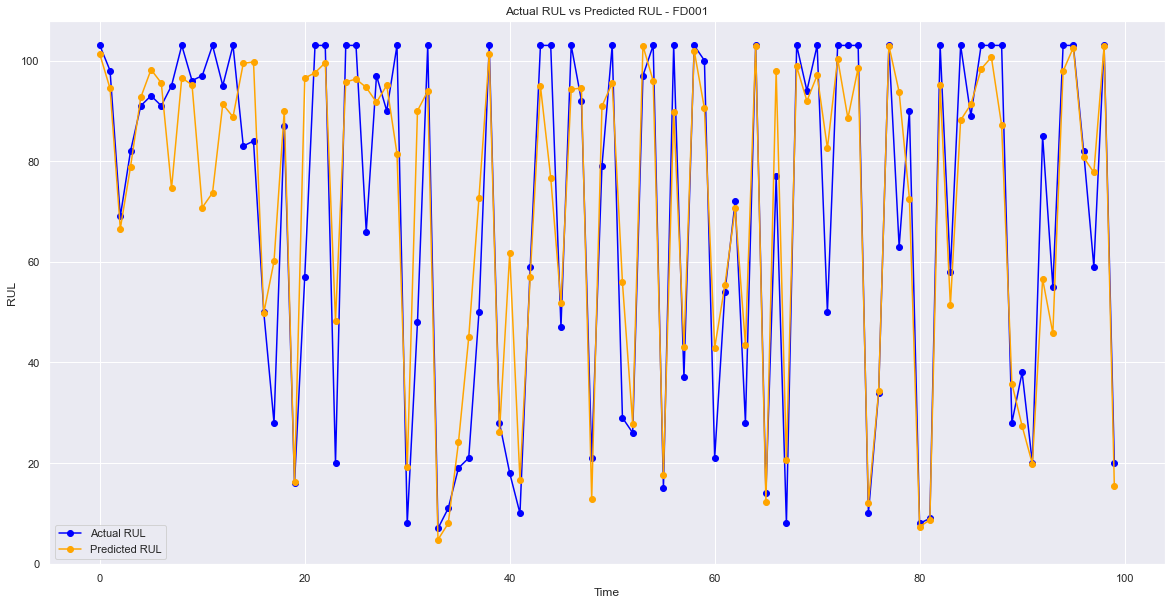

In [96]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_test and y_hat_test_bi_tcn are your actual and predicted RUL values
plt.figure(figsize=(20, 10))

# Line chart for actual RUL
plt.plot(y_test, label='Actual RUL', marker='o', linestyle='-', color='blue')

# Line chart for predicted RUL
plt.plot(y_hat_test_rf, label='Predicted RUL', marker='o', linestyle='-', color='orange')

plt.title('Actual RUL vs Predicted RUL - FD001')
plt.xlabel('Time')
plt.ylabel('RUL')
plt.legend()
plt.grid(True)
plt.show()


## Conclusion

In [97]:
Results

Model  RMSE-Train  R2-Train  \
0                                             BiLSTM   14.971241  0.799399   
1                                             BiTRNN   15.063579  0.796917   
2                                              BiGRU   14.961377  0.799664   
3                                            ProgNet   15.923958  0.773056   
4                                               DCNN   15.416913  0.787278   
5  Ensemble (Bi-LSTM + Bi-TRNN + Bi-GRU + DCNN + ...    0.000000  1.000000   
6                           Random Forest (Ensemble)   13.150283  0.845230   

   RMSE-Test   R2-Test  
0  14.860500  0.820524  
1  15.009129  0.816916  
2  14.802107  0.821932  
3  15.768690  0.797917  
4  15.308774  0.809533  
5  21.069646  0.639211  
6  14.496490  0.829209

## Base Paper Result

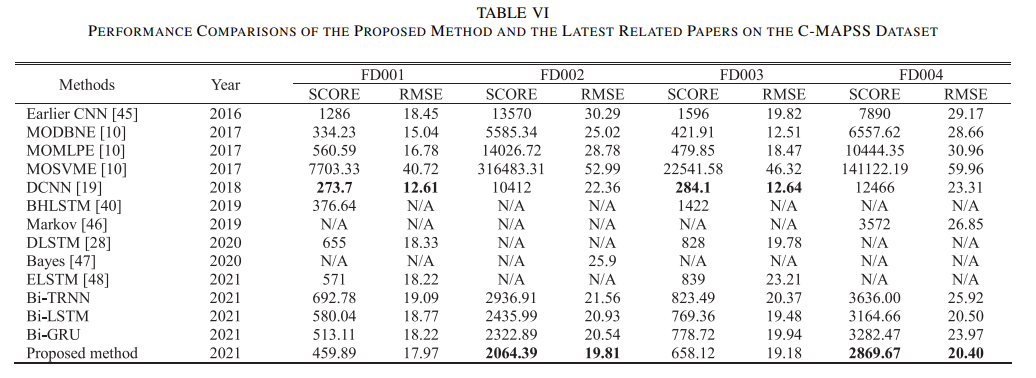